In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import packages
import numpy as np
import pandas as pd
import datetime as dt

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

# Time series analysis
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [2]:
# load the data
X = pd.read_csv('X.csv', low_memory=False)

In [3]:
train_total = X.sort_values(['Date'], ascending=False)
train_total.head()

,Date,Store,DayOfWeek,Sales,Customers,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,CompetitionDuration,Promo2Duration,IsPromo2month
0,2015-07-31,1,5,5263,555,1,0,1,2015,7,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,82.0,0.00,0
231327,2015-07-31,309,5,8688,707,1,0,1,2015,7,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,70.50,0
722843,2015-07-31,958,5,4357,562,1,0,1,2015,7,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,20.0,0.00,0
52218,2015-07-31,70,5,8613,741,1,0,1,2015,7,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00,0
784274,2015-07-31,1039,5,9479,1063,1,0,1,2015,7,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,301.0,38.25,0


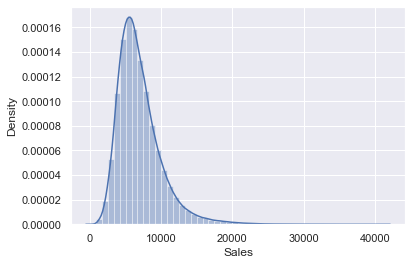

In [4]:
sns.distplot(train_total.Sales); # we need to log tranform Sales as it is skewed.

In [5]:
# 90/10 split data into train and valid sets
train = train_total[int(0.1*len(train_total)):]
valid = train_total[:int(0.1*len(train_total))]

In [6]:
X_train = train.drop(['Date','Customers','Sales'],axis=1)
y_train = np.log(train.Sales)

X_valid = valid.drop(['Date','Customers','Sales'],axis=1)
y_valid = np.log(valid.Sales)

### Random Forest Regressor

In [7]:
# Random Forest Regressor
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

# Prediction
y_pred = rfr.predict(X_valid)

#### Model Evaluation

In [8]:
# RMSE 
from sklearn.metrics import mean_squared_error

def RMSE(y_valid, y_pred):
    
    return np.sqrt(mean_squared_error(y_valid, y_pred))
  
# Print the error:
print("Valid RMSE: %.4f" % RMSE(y_valid, y_pred))

Valid RMSE: 0.1530


However, if you want to entre the competition at Kaggle, the submissions are evaluated on the Root Mean Square Percentage Error (RMSPE). The RMSPE is calculated as

$$RMSPE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2}$$

where $y_i$ denotes the sales of a single store on a single day and $\hat{y}_i$ denotes the corresponding prediction. Any day and store with 0 sales is ignored in scoring.

In [9]:
def rmspe(y_true, y_hat):
    loss = np.sqrt(np.mean(np.square(((y_true - y_hat)/y_true))))
    return loss

In [10]:
def rmspe_xg(yhat, y):
    y = np.exp(y.get_label())   #inverse of log()
    yhat = np.exp(yhat)
    return "rmspe", rmspe(y, yhat)

In [11]:
error = rmspe(np.exp(y_valid), np.exp(y_pred)) 

# Print the error:
print("Valid RMSPE: %.4f" % error)

Valid RMSPE: 0.1568


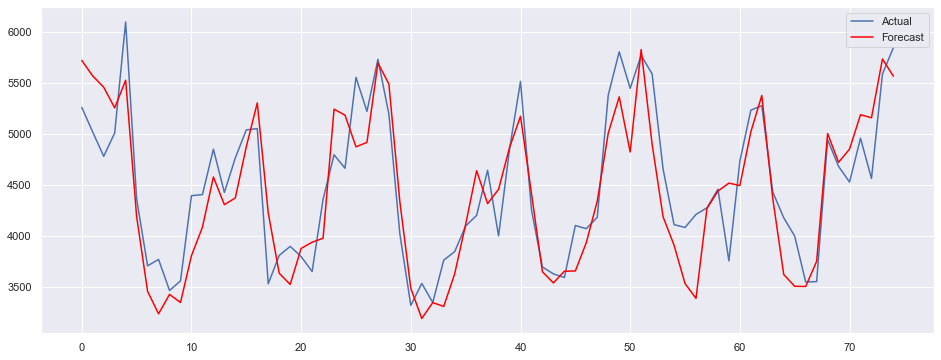

In [12]:
# Creat a copy of the valid data
df_pred = valid.copy()
# Add the forecasts
df_pred['Forecast'] = np.exp(y_pred)

# Plot Actual vs. Forecast for Store 1.
plt.figure(figsize=(16, 6))
plt.plot(df_pred[df_pred.Store == 1]['Sales'],label='Actual')
plt.plot(df_pred[df_pred.Store == 1]['Forecast'], 
         color='red', label='Forecast')
plt.legend();

#### Model Fine-Tuning: GridSearch

You can mannually change parameters in a model but it would be time-comsuming. 
We use Scikit-Learn’s GridSearchCV to search for best possible parameters, using cross-validation.

In [13]:
from sklearn.model_selection import GridSearchCV   
from sklearn.metrics import make_scorer

params = {'n_estimators': [200,400,500],
         'max_features': [10,15,20]}

"""WARNING: The following search can be very time-consuming"""
rfr = RandomForestRegressor()

GS = GridSearchCV(rfr, param_grid=params, cv=5,
            scoring=make_scorer(rmspe,greater_is_better=False))
GS.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [10, 15, 20],
                         'n_estimators': [200, 400, 500]},
             scoring=make_scorer(rmspe, greater_is_better=False))

In [14]:
GS.best_params_

{'max_features': 15, 'n_estimators': 500}

In [15]:
GS.best_estimator_

RandomForestRegressor(max_features=15, n_estimators=500)

In [16]:
rfr_final = GS.best_estimator_
rfr_final.fit(X_train, y_train)
y_pred = rfr_final.predict(X_valid)

error = rmspe(np.exp(y_valid), np.exp(y_pred))
# Print the error:
print("Valid RMSPE: %.4f" % error)

Valid RMSPE: 0.1455


Not a bad result! Since we have only tried couple of parameters,you should try other values to possibly improve your model.

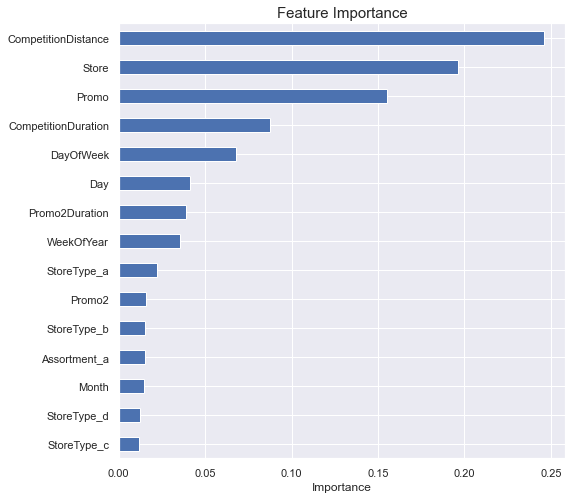

In [17]:
# Plot feature importance
feature_rank = pd.Series(rfr_final.feature_importances_,
                         index=X_train.columns)

plt.figure(figsize=(8,8))
feature_rank.nlargest(15).sort_values(ascending=True).\
                                      plot(kind='barh')
plt.xlabel('Importance')
plt.title('Feature Importance', fontsize =15);

#### Summary

Our RandomForest model returned a RMSPE of 0.1455 after running on our validation set, which is very good. 

However, you might still be able to improve your forecasting accuracy by applying the one of the following approaches,

- Allocate more data to the training set when splitting so that the algorithm has more data to train on.

- Adjust the hyperparameters to reach a better optimal combination.(which can take very long time)

- Use different ML algorithms, e.g. XGboost, Neural Network etc.


### XGBoost

XGBoost stands for “Extreme Gradient Boosting”.

Boosting trains models in succession. The new models are added sequentially by correcting the mistakes created by previous ones until no further improvements can be made. This method is much better than a standard ensemble method where models are trained in isolation and might simply end up making the same mistakes.

Gradient boosting create and add decision trees to an ensemble model sequentially. New trees are created to correct the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

Generally, XGBoost is fast and of high accuracy. Let's try it!

#### Parameters Setting 

**Note**:
XGBoost does not support categorical features; if a dataset contains categorical features, load it as a NumPy array first and then perform one-hot encoding.


In [35]:
# Preparing data
dtrain = xgb.DMatrix(X_train, label=y_train)         
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Specify validation set to watch performance
evallist = [(dtrain, 'train'), (dvalid, 'valid')]     

In [34]:
# Initialising parameters
params = {"booster" : "gbtree",             #use tree based model - default
          "objective": "reg:squarederror",  #regression with squared loss
          "eta": 0.03,                      #learning rate to prevent overfitting
          "max_depth": 8,                   #maximum depth of a tree
          "subsample": 0.95,                #subsample ratio of the training set
          "colsample_bytree": 0.75,         #subsample ratio of the features
          "seed": 42 }                      #for reproducible results
           

num_round = 6000                             #number of boosting iterations

#### Model Training

If you have a validation set, you can use early stopping to find the optimal number of boosting rounds.

In [36]:
bst = xgb.train(params=params, dtrain=dtrain, 
                num_boost_round=num_round, 
                evals=evallist, early_stopping_rounds=100, 
                feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:8.01646	train-rmspe:0.99963	valid-rmse:8.06237	valid-rmspe:0.99965
[1]	train-rmse:7.77653	train-rmspe:0.99953	valid-rmse:7.82191	valid-rmspe:0.99956
[2]	train-rmse:7.54381	train-rmspe:0.99941	valid-rmse:7.58951	valid-rmspe:0.99945
[3]	train-rmse:7.31799	train-rmspe:0.99927	valid-rmse:7.36397	valid-rmspe:0.99931
[4]	train-rmse:7.09898	train-rmspe:0.99909	valid-rmse:7.14546	valid-rmspe:0.99914
[5]	train-rmse:6.88655	train-rmspe:0.99887	valid-rmse:6.93332	valid-rmspe:0.99894
[6]	train-rmse:6.68055	train-rmspe:0.99862	valid-rmse:6.72708	valid-rmspe:0.99869
[7]	train-rmse:6.48072	train-rmspe:0.99831	valid-rmse:6.52737	valid-rmspe:0.99840
[8]	train-rmse:6.28689	train-rmspe:0.99796	valid-rmse:6.33380	valid-rmspe:0.99806
[9]	train-rmse:6.09891	train-rmspe:0.99754	valid-rmse:6.14590	valid-rmspe:0.99767
[10]	train-rmse:5.91654	train-rmspe:0.99705	valid-rmse:5.96370	valid-rmspe:0.99720
[11]	train-rmse:5.73968	train-rmspe:0.99648	valid-rmse:5.78689	valid-rmspe:0.99667
[12]	train-rms

[99]	train-rmse:0.49424	train-rmspe:0.38243	valid-rmse:0.52851	valid-rmspe:0.38675
[100]	train-rmse:0.48470	train-rmspe:0.37783	valid-rmse:0.51827	valid-rmspe:0.38122
[101]	train-rmse:0.47516	train-rmspe:0.37323	valid-rmse:0.50858	valid-rmspe:0.37595
[102]	train-rmse:0.46629	train-rmspe:0.36899	valid-rmse:0.49950	valid-rmspe:0.37097
[103]	train-rmse:0.45766	train-rmspe:0.36481	valid-rmse:0.49056	valid-rmspe:0.36603
[104]	train-rmse:0.44966	train-rmspe:0.36112	valid-rmse:0.48192	valid-rmspe:0.36139
[105]	train-rmse:0.44199	train-rmspe:0.35767	valid-rmse:0.47385	valid-rmspe:0.35706
[106]	train-rmse:0.43437	train-rmspe:0.35420	valid-rmse:0.46596	valid-rmspe:0.35280
[107]	train-rmse:0.42715	train-rmspe:0.35107	valid-rmse:0.45843	valid-rmspe:0.34873
[108]	train-rmse:0.42023	train-rmspe:0.34808	valid-rmse:0.45100	valid-rmspe:0.34480
[109]	train-rmse:0.41362	train-rmspe:0.34529	valid-rmse:0.44394	valid-rmspe:0.34108
[110]	train-rmse:0.40724	train-rmspe:0.34261	valid-rmse:0.43726	valid-rmspe:0

[197]	train-rmse:0.25435	train-rmspe:0.30701	valid-rmse:0.26827	valid-rmspe:0.26985
[198]	train-rmse:0.25423	train-rmspe:0.30722	valid-rmse:0.26807	valid-rmspe:0.26991
[199]	train-rmse:0.25372	train-rmspe:0.30687	valid-rmse:0.26754	valid-rmspe:0.26947
[200]	train-rmse:0.25331	train-rmspe:0.30675	valid-rmse:0.26709	valid-rmspe:0.26920
[201]	train-rmse:0.25317	train-rmspe:0.30686	valid-rmse:0.26694	valid-rmspe:0.26935
[202]	train-rmse:0.25299	train-rmspe:0.30691	valid-rmse:0.26669	valid-rmspe:0.26930
[203]	train-rmse:0.25288	train-rmspe:0.30711	valid-rmse:0.26652	valid-rmspe:0.26935
[204]	train-rmse:0.25259	train-rmspe:0.30697	valid-rmse:0.26620	valid-rmspe:0.26913
[205]	train-rmse:0.25142	train-rmspe:0.30585	valid-rmse:0.26505	valid-rmspe:0.26801
[206]	train-rmse:0.25126	train-rmspe:0.30588	valid-rmse:0.26481	valid-rmspe:0.26815
[207]	train-rmse:0.25095	train-rmspe:0.30570	valid-rmse:0.26453	valid-rmspe:0.26820
[208]	train-rmse:0.25073	train-rmspe:0.30571	valid-rmse:0.26427	valid-rmspe:

[295]	train-rmse:0.21964	train-rmspe:0.27868	valid-rmse:0.23544	valid-rmspe:0.24367
[296]	train-rmse:0.21911	train-rmspe:0.27821	valid-rmse:0.23492	valid-rmspe:0.24317
[297]	train-rmse:0.21904	train-rmspe:0.27821	valid-rmse:0.23485	valid-rmspe:0.24311
[298]	train-rmse:0.21898	train-rmspe:0.27823	valid-rmse:0.23478	valid-rmspe:0.24307
[299]	train-rmse:0.21885	train-rmspe:0.27811	valid-rmse:0.23466	valid-rmspe:0.24295
[300]	train-rmse:0.21872	train-rmspe:0.27798	valid-rmse:0.23457	valid-rmspe:0.24285
[301]	train-rmse:0.21864	train-rmspe:0.27797	valid-rmse:0.23450	valid-rmspe:0.24280
[302]	train-rmse:0.21807	train-rmspe:0.27735	valid-rmse:0.23402	valid-rmspe:0.24230
[303]	train-rmse:0.21798	train-rmspe:0.27727	valid-rmse:0.23393	valid-rmspe:0.24221
[304]	train-rmse:0.21741	train-rmspe:0.27676	valid-rmse:0.23334	valid-rmspe:0.24155
[305]	train-rmse:0.21734	train-rmspe:0.27676	valid-rmse:0.23328	valid-rmspe:0.24149
[306]	train-rmse:0.21718	train-rmspe:0.27663	valid-rmse:0.23311	valid-rmspe:

[393]	train-rmse:0.19479	train-rmspe:0.25450	valid-rmse:0.21402	valid-rmspe:0.22205
[394]	train-rmse:0.19473	train-rmspe:0.25461	valid-rmse:0.21396	valid-rmspe:0.22199
[395]	train-rmse:0.19465	train-rmspe:0.25451	valid-rmse:0.21392	valid-rmspe:0.22194
[396]	train-rmse:0.19447	train-rmspe:0.25433	valid-rmse:0.21374	valid-rmspe:0.22173
[397]	train-rmse:0.19406	train-rmspe:0.25389	valid-rmse:0.21342	valid-rmspe:0.22142
[398]	train-rmse:0.19400	train-rmspe:0.25400	valid-rmse:0.21336	valid-rmspe:0.22136
[399]	train-rmse:0.19392	train-rmspe:0.25392	valid-rmse:0.21332	valid-rmspe:0.22132
[400]	train-rmse:0.19384	train-rmspe:0.25385	valid-rmse:0.21324	valid-rmspe:0.22128
[401]	train-rmse:0.19339	train-rmspe:0.25343	valid-rmse:0.21281	valid-rmspe:0.22076
[402]	train-rmse:0.19332	train-rmspe:0.25336	valid-rmse:0.21274	valid-rmspe:0.22069
[403]	train-rmse:0.19301	train-rmspe:0.25308	valid-rmse:0.21249	valid-rmspe:0.22041
[404]	train-rmse:0.19285	train-rmspe:0.25294	valid-rmse:0.21236	valid-rmspe:

[491]	train-rmse:0.17334	train-rmspe:0.23504	valid-rmse:0.19599	valid-rmspe:0.20301
[492]	train-rmse:0.17319	train-rmspe:0.23491	valid-rmse:0.19584	valid-rmspe:0.20287
[493]	train-rmse:0.17315	train-rmspe:0.23488	valid-rmse:0.19579	valid-rmspe:0.20282
[494]	train-rmse:0.17280	train-rmspe:0.23457	valid-rmse:0.19555	valid-rmspe:0.20258
[495]	train-rmse:0.17245	train-rmspe:0.23425	valid-rmse:0.19523	valid-rmspe:0.20223
[496]	train-rmse:0.17236	train-rmspe:0.23433	valid-rmse:0.19514	valid-rmspe:0.20214
[497]	train-rmse:0.17213	train-rmspe:0.23408	valid-rmse:0.19496	valid-rmspe:0.20195
[498]	train-rmse:0.17190	train-rmspe:0.23252	valid-rmse:0.19476	valid-rmspe:0.20176
[499]	train-rmse:0.17172	train-rmspe:0.23233	valid-rmse:0.19459	valid-rmspe:0.20158
[500]	train-rmse:0.17140	train-rmspe:0.23203	valid-rmse:0.19431	valid-rmspe:0.20126
[501]	train-rmse:0.17125	train-rmspe:0.23188	valid-rmse:0.19415	valid-rmspe:0.20110
[502]	train-rmse:0.17097	train-rmspe:0.23163	valid-rmse:0.19388	valid-rmspe:

[589]	train-rmse:0.15829	train-rmspe:0.21392	valid-rmse:0.18400	valid-rmspe:0.19037
[590]	train-rmse:0.15815	train-rmspe:0.21374	valid-rmse:0.18390	valid-rmspe:0.19027
[591]	train-rmse:0.15810	train-rmspe:0.21370	valid-rmse:0.18386	valid-rmspe:0.19024
[592]	train-rmse:0.15801	train-rmspe:0.21357	valid-rmse:0.18386	valid-rmspe:0.19025
[593]	train-rmse:0.15789	train-rmspe:0.21347	valid-rmse:0.18377	valid-rmspe:0.19015
[594]	train-rmse:0.15786	train-rmspe:0.21346	valid-rmse:0.18374	valid-rmspe:0.19013
[595]	train-rmse:0.15783	train-rmspe:0.21350	valid-rmse:0.18371	valid-rmspe:0.19009
[596]	train-rmse:0.15768	train-rmspe:0.21337	valid-rmse:0.18358	valid-rmspe:0.18993
[597]	train-rmse:0.15735	train-rmspe:0.21305	valid-rmse:0.18328	valid-rmspe:0.18957
[598]	train-rmse:0.15732	train-rmspe:0.21302	valid-rmse:0.18325	valid-rmspe:0.18954
[599]	train-rmse:0.15724	train-rmspe:0.21296	valid-rmse:0.18317	valid-rmspe:0.18946
[600]	train-rmse:0.15720	train-rmspe:0.21292	valid-rmse:0.18314	valid-rmspe:

[687]	train-rmse:0.14779	train-rmspe:0.20116	valid-rmse:0.17624	valid-rmspe:0.18186
[688]	train-rmse:0.14767	train-rmspe:0.20106	valid-rmse:0.17614	valid-rmspe:0.18174
[689]	train-rmse:0.14746	train-rmspe:0.20088	valid-rmse:0.17595	valid-rmspe:0.18153
[690]	train-rmse:0.14730	train-rmspe:0.20075	valid-rmse:0.17581	valid-rmspe:0.18138
[691]	train-rmse:0.14719	train-rmspe:0.20061	valid-rmse:0.17573	valid-rmspe:0.18129
[692]	train-rmse:0.14717	train-rmspe:0.20059	valid-rmse:0.17571	valid-rmspe:0.18127
[693]	train-rmse:0.14713	train-rmspe:0.20056	valid-rmse:0.17569	valid-rmspe:0.18125
[694]	train-rmse:0.14710	train-rmspe:0.20061	valid-rmse:0.17566	valid-rmspe:0.18122
[695]	train-rmse:0.14708	train-rmspe:0.20059	valid-rmse:0.17566	valid-rmspe:0.18122
[696]	train-rmse:0.14696	train-rmspe:0.20049	valid-rmse:0.17556	valid-rmspe:0.18112
[697]	train-rmse:0.14684	train-rmspe:0.20040	valid-rmse:0.17547	valid-rmspe:0.18103
[698]	train-rmse:0.14672	train-rmspe:0.20027	valid-rmse:0.17536	valid-rmspe:

[785]	train-rmse:0.13922	train-rmspe:0.19009	valid-rmse:0.16964	valid-rmspe:0.17482
[786]	train-rmse:0.13907	train-rmspe:0.18993	valid-rmse:0.16951	valid-rmspe:0.17468
[787]	train-rmse:0.13889	train-rmspe:0.18977	valid-rmse:0.16934	valid-rmspe:0.17448
[788]	train-rmse:0.13871	train-rmspe:0.18963	valid-rmse:0.16918	valid-rmspe:0.17430
[789]	train-rmse:0.13861	train-rmspe:0.18952	valid-rmse:0.16909	valid-rmspe:0.17422
[790]	train-rmse:0.13845	train-rmspe:0.18939	valid-rmse:0.16896	valid-rmspe:0.17408
[791]	train-rmse:0.13836	train-rmspe:0.18931	valid-rmse:0.16888	valid-rmspe:0.17400
[792]	train-rmse:0.13833	train-rmspe:0.18929	valid-rmse:0.16886	valid-rmspe:0.17398
[793]	train-rmse:0.13821	train-rmspe:0.18911	valid-rmse:0.16876	valid-rmspe:0.17389
[794]	train-rmse:0.13814	train-rmspe:0.18906	valid-rmse:0.16869	valid-rmspe:0.17380
[795]	train-rmse:0.13811	train-rmspe:0.18911	valid-rmse:0.16866	valid-rmspe:0.17378
[796]	train-rmse:0.13801	train-rmspe:0.18903	valid-rmse:0.16857	valid-rmspe:

[883]	train-rmse:0.13253	train-rmspe:0.18194	valid-rmse:0.16420	valid-rmspe:0.16901
[884]	train-rmse:0.13244	train-rmspe:0.18186	valid-rmse:0.16411	valid-rmspe:0.16892
[885]	train-rmse:0.13239	train-rmspe:0.18182	valid-rmse:0.16406	valid-rmspe:0.16887
[886]	train-rmse:0.13228	train-rmspe:0.18170	valid-rmse:0.16397	valid-rmspe:0.16877
[887]	train-rmse:0.13227	train-rmspe:0.18169	valid-rmse:0.16396	valid-rmspe:0.16876
[888]	train-rmse:0.13219	train-rmspe:0.18163	valid-rmse:0.16389	valid-rmspe:0.16869
[889]	train-rmse:0.13217	train-rmspe:0.18157	valid-rmse:0.16389	valid-rmspe:0.16870
[890]	train-rmse:0.13209	train-rmspe:0.18150	valid-rmse:0.16381	valid-rmspe:0.16861
[891]	train-rmse:0.13198	train-rmspe:0.18141	valid-rmse:0.16374	valid-rmspe:0.16853
[892]	train-rmse:0.13196	train-rmspe:0.18139	valid-rmse:0.16373	valid-rmspe:0.16852
[893]	train-rmse:0.13189	train-rmspe:0.18133	valid-rmse:0.16366	valid-rmspe:0.16845
[894]	train-rmse:0.13182	train-rmspe:0.18128	valid-rmse:0.16359	valid-rmspe:

[981]	train-rmse:0.12700	train-rmspe:0.17393	valid-rmse:0.15977	valid-rmspe:0.16432
[982]	train-rmse:0.12694	train-rmspe:0.17388	valid-rmse:0.15974	valid-rmspe:0.16428
[983]	train-rmse:0.12690	train-rmspe:0.17383	valid-rmse:0.15974	valid-rmspe:0.16421
[984]	train-rmse:0.12684	train-rmspe:0.17378	valid-rmse:0.15976	valid-rmspe:0.16419
[985]	train-rmse:0.12678	train-rmspe:0.17371	valid-rmse:0.15970	valid-rmspe:0.16413
[986]	train-rmse:0.12676	train-rmspe:0.17368	valid-rmse:0.15968	valid-rmspe:0.16411
[987]	train-rmse:0.12670	train-rmspe:0.17359	valid-rmse:0.15967	valid-rmspe:0.16409
[988]	train-rmse:0.12664	train-rmspe:0.17352	valid-rmse:0.15970	valid-rmspe:0.16410
[989]	train-rmse:0.12660	train-rmspe:0.17348	valid-rmse:0.15966	valid-rmspe:0.16409
[990]	train-rmse:0.12656	train-rmspe:0.17344	valid-rmse:0.15962	valid-rmspe:0.16405
[991]	train-rmse:0.12648	train-rmspe:0.17339	valid-rmse:0.15956	valid-rmspe:0.16398
[992]	train-rmse:0.12643	train-rmspe:0.17334	valid-rmse:0.15951	valid-rmspe:

[1078]	train-rmse:0.12230	train-rmspe:0.16591	valid-rmse:0.15611	valid-rmspe:0.16034
[1079]	train-rmse:0.12225	train-rmspe:0.16587	valid-rmse:0.15608	valid-rmspe:0.16031
[1080]	train-rmse:0.12223	train-rmspe:0.16585	valid-rmse:0.15607	valid-rmspe:0.16030
[1081]	train-rmse:0.12222	train-rmspe:0.16584	valid-rmse:0.15607	valid-rmspe:0.16029
[1082]	train-rmse:0.12219	train-rmspe:0.16581	valid-rmse:0.15604	valid-rmspe:0.16026
[1083]	train-rmse:0.12212	train-rmspe:0.16575	valid-rmse:0.15592	valid-rmspe:0.16014
[1084]	train-rmse:0.12207	train-rmspe:0.16568	valid-rmse:0.15591	valid-rmspe:0.16012
[1085]	train-rmse:0.12199	train-rmspe:0.16562	valid-rmse:0.15584	valid-rmspe:0.16004
[1086]	train-rmse:0.12190	train-rmspe:0.16546	valid-rmse:0.15575	valid-rmspe:0.15993
[1087]	train-rmse:0.12187	train-rmspe:0.16542	valid-rmse:0.15584	valid-rmspe:0.16009
[1088]	train-rmse:0.12181	train-rmspe:0.16536	valid-rmse:0.15580	valid-rmspe:0.16004
[1089]	train-rmse:0.12178	train-rmspe:0.16534	valid-rmse:0.15577	

[1175]	train-rmse:0.11807	train-rmspe:0.15981	valid-rmse:0.15299	valid-rmspe:0.15691
[1176]	train-rmse:0.11796	train-rmspe:0.15971	valid-rmse:0.15291	valid-rmspe:0.15685
[1177]	train-rmse:0.11787	train-rmspe:0.15964	valid-rmse:0.15284	valid-rmspe:0.15677
[1178]	train-rmse:0.11784	train-rmspe:0.15961	valid-rmse:0.15281	valid-rmspe:0.15675
[1179]	train-rmse:0.11783	train-rmspe:0.15960	valid-rmse:0.15281	valid-rmspe:0.15674
[1180]	train-rmse:0.11781	train-rmspe:0.15959	valid-rmse:0.15279	valid-rmspe:0.15673
[1181]	train-rmse:0.11779	train-rmspe:0.15957	valid-rmse:0.15278	valid-rmspe:0.15672
[1182]	train-rmse:0.11777	train-rmspe:0.15955	valid-rmse:0.15276	valid-rmspe:0.15669
[1183]	train-rmse:0.11771	train-rmspe:0.15948	valid-rmse:0.15270	valid-rmspe:0.15663
[1184]	train-rmse:0.11766	train-rmspe:0.15944	valid-rmse:0.15265	valid-rmspe:0.15657
[1185]	train-rmse:0.11763	train-rmspe:0.15937	valid-rmse:0.15268	valid-rmspe:0.15665
[1186]	train-rmse:0.11761	train-rmspe:0.15935	valid-rmse:0.15267	

[1272]	train-rmse:0.11486	train-rmspe:0.15599	valid-rmse:0.15070	valid-rmspe:0.15465
[1273]	train-rmse:0.11482	train-rmspe:0.15595	valid-rmse:0.15067	valid-rmspe:0.15461
[1274]	train-rmse:0.11480	train-rmspe:0.15592	valid-rmse:0.15065	valid-rmspe:0.15459
[1275]	train-rmse:0.11474	train-rmspe:0.15586	valid-rmse:0.15060	valid-rmspe:0.15452
[1276]	train-rmse:0.11466	train-rmspe:0.15578	valid-rmse:0.15056	valid-rmspe:0.15446
[1277]	train-rmse:0.11463	train-rmspe:0.15576	valid-rmse:0.15054	valid-rmspe:0.15445
[1278]	train-rmse:0.11463	train-rmspe:0.15576	valid-rmse:0.15054	valid-rmspe:0.15445
[1279]	train-rmse:0.11458	train-rmspe:0.15572	valid-rmse:0.15053	valid-rmspe:0.15442
[1280]	train-rmse:0.11456	train-rmspe:0.15567	valid-rmse:0.15055	valid-rmspe:0.15443
[1281]	train-rmse:0.11453	train-rmspe:0.15564	valid-rmse:0.15054	valid-rmspe:0.15441
[1282]	train-rmse:0.11449	train-rmspe:0.15561	valid-rmse:0.15050	valid-rmspe:0.15438
[1283]	train-rmse:0.11446	train-rmspe:0.15558	valid-rmse:0.15047	

[1369]	train-rmse:0.11175	train-rmspe:0.15296	valid-rmse:0.14861	valid-rmspe:0.15252
[1370]	train-rmse:0.11171	train-rmspe:0.15293	valid-rmse:0.14858	valid-rmspe:0.15249
[1371]	train-rmse:0.11167	train-rmspe:0.15288	valid-rmse:0.14854	valid-rmspe:0.15245
[1372]	train-rmse:0.11164	train-rmspe:0.15286	valid-rmse:0.14851	valid-rmspe:0.15243
[1373]	train-rmse:0.11162	train-rmspe:0.15284	valid-rmse:0.14851	valid-rmspe:0.15242
[1374]	train-rmse:0.11160	train-rmspe:0.15282	valid-rmse:0.14849	valid-rmspe:0.15241
[1375]	train-rmse:0.11156	train-rmspe:0.15279	valid-rmse:0.14850	valid-rmspe:0.15240
[1376]	train-rmse:0.11153	train-rmspe:0.15277	valid-rmse:0.14847	valid-rmspe:0.15237
[1377]	train-rmse:0.11152	train-rmspe:0.15275	valid-rmse:0.14846	valid-rmspe:0.15235
[1378]	train-rmse:0.11147	train-rmspe:0.15272	valid-rmse:0.14843	valid-rmspe:0.15232
[1379]	train-rmse:0.11144	train-rmspe:0.15267	valid-rmse:0.14841	valid-rmspe:0.15230
[1380]	train-rmse:0.11143	train-rmspe:0.15266	valid-rmse:0.14839	

[1466]	train-rmse:0.10948	train-rmspe:0.15001	valid-rmse:0.14735	valid-rmspe:0.15112
[1467]	train-rmse:0.10946	train-rmspe:0.14999	valid-rmse:0.14734	valid-rmspe:0.15110
[1468]	train-rmse:0.10942	train-rmspe:0.14995	valid-rmse:0.14730	valid-rmspe:0.15106
[1469]	train-rmse:0.10940	train-rmspe:0.14994	valid-rmse:0.14729	valid-rmspe:0.15105
[1470]	train-rmse:0.10937	train-rmspe:0.14991	valid-rmse:0.14727	valid-rmspe:0.15103
[1471]	train-rmse:0.10936	train-rmspe:0.14990	valid-rmse:0.14727	valid-rmspe:0.15103
[1472]	train-rmse:0.10933	train-rmspe:0.14987	valid-rmse:0.14728	valid-rmspe:0.15104
[1473]	train-rmse:0.10931	train-rmspe:0.14985	valid-rmse:0.14726	valid-rmspe:0.15102
[1474]	train-rmse:0.10927	train-rmspe:0.14982	valid-rmse:0.14724	valid-rmspe:0.15099
[1475]	train-rmse:0.10926	train-rmspe:0.14980	valid-rmse:0.14724	valid-rmspe:0.15100
[1476]	train-rmse:0.10923	train-rmspe:0.14979	valid-rmse:0.14723	valid-rmspe:0.15098
[1477]	train-rmse:0.10921	train-rmspe:0.14978	valid-rmse:0.14722	

[1563]	train-rmse:0.10725	train-rmspe:0.14766	valid-rmse:0.14602	valid-rmspe:0.14960
[1564]	train-rmse:0.10723	train-rmspe:0.14764	valid-rmse:0.14600	valid-rmspe:0.14959
[1565]	train-rmse:0.10722	train-rmspe:0.14763	valid-rmse:0.14600	valid-rmspe:0.14958
[1566]	train-rmse:0.10719	train-rmspe:0.14760	valid-rmse:0.14598	valid-rmspe:0.14957
[1567]	train-rmse:0.10717	train-rmspe:0.14758	valid-rmse:0.14597	valid-rmspe:0.14956
[1568]	train-rmse:0.10713	train-rmspe:0.14756	valid-rmse:0.14594	valid-rmspe:0.14952
[1569]	train-rmse:0.10709	train-rmspe:0.14749	valid-rmse:0.14591	valid-rmspe:0.14949
[1570]	train-rmse:0.10709	train-rmspe:0.14749	valid-rmse:0.14591	valid-rmspe:0.14949
[1571]	train-rmse:0.10708	train-rmspe:0.14747	valid-rmse:0.14590	valid-rmspe:0.14948
[1572]	train-rmse:0.10705	train-rmspe:0.14745	valid-rmse:0.14588	valid-rmspe:0.14947
[1573]	train-rmse:0.10705	train-rmspe:0.14744	valid-rmse:0.14588	valid-rmspe:0.14947
[1574]	train-rmse:0.10704	train-rmspe:0.14744	valid-rmse:0.14588	

[1660]	train-rmse:0.10537	train-rmspe:0.14527	valid-rmse:0.14518	valid-rmspe:0.14856
[1661]	train-rmse:0.10536	train-rmspe:0.14525	valid-rmse:0.14518	valid-rmspe:0.14856
[1662]	train-rmse:0.10535	train-rmspe:0.14524	valid-rmse:0.14519	valid-rmspe:0.14856
[1663]	train-rmse:0.10535	train-rmspe:0.14524	valid-rmse:0.14519	valid-rmspe:0.14856
[1664]	train-rmse:0.10533	train-rmspe:0.14522	valid-rmse:0.14519	valid-rmspe:0.14855
[1665]	train-rmse:0.10531	train-rmspe:0.14520	valid-rmse:0.14519	valid-rmspe:0.14857
[1666]	train-rmse:0.10528	train-rmspe:0.14518	valid-rmse:0.14517	valid-rmspe:0.14855
[1667]	train-rmse:0.10527	train-rmspe:0.14518	valid-rmse:0.14517	valid-rmspe:0.14854
[1668]	train-rmse:0.10526	train-rmspe:0.14516	valid-rmse:0.14517	valid-rmspe:0.14855
[1669]	train-rmse:0.10524	train-rmspe:0.14518	valid-rmse:0.14516	valid-rmspe:0.14853
[1670]	train-rmse:0.10522	train-rmspe:0.14518	valid-rmse:0.14514	valid-rmspe:0.14852
[1671]	train-rmse:0.10520	train-rmspe:0.14517	valid-rmse:0.14513	

[1757]	train-rmse:0.10349	train-rmspe:0.14377	valid-rmse:0.14414	valid-rmspe:0.14739
[1758]	train-rmse:0.10348	train-rmspe:0.14376	valid-rmse:0.14414	valid-rmspe:0.14738
[1759]	train-rmse:0.10347	train-rmspe:0.14374	valid-rmse:0.14414	valid-rmspe:0.14738
[1760]	train-rmse:0.10345	train-rmspe:0.14373	valid-rmse:0.14413	valid-rmspe:0.14737
[1761]	train-rmse:0.10344	train-rmspe:0.14371	valid-rmse:0.14413	valid-rmspe:0.14736
[1762]	train-rmse:0.10342	train-rmspe:0.14369	valid-rmse:0.14412	valid-rmspe:0.14735
[1763]	train-rmse:0.10340	train-rmspe:0.14367	valid-rmse:0.14411	valid-rmspe:0.14736
[1764]	train-rmse:0.10339	train-rmspe:0.14359	valid-rmse:0.14411	valid-rmspe:0.14735
[1765]	train-rmse:0.10337	train-rmspe:0.14355	valid-rmse:0.14412	valid-rmspe:0.14737
[1766]	train-rmse:0.10332	train-rmspe:0.14350	valid-rmse:0.14408	valid-rmspe:0.14732
[1767]	train-rmse:0.10330	train-rmspe:0.14349	valid-rmse:0.14406	valid-rmspe:0.14730
[1768]	train-rmse:0.10330	train-rmspe:0.14349	valid-rmse:0.14406	

[1854]	train-rmse:0.10205	train-rmspe:0.14082	valid-rmse:0.14353	valid-rmspe:0.14665
[1855]	train-rmse:0.10204	train-rmspe:0.14079	valid-rmse:0.14353	valid-rmspe:0.14664
[1856]	train-rmse:0.10202	train-rmspe:0.14078	valid-rmse:0.14352	valid-rmspe:0.14663
[1857]	train-rmse:0.10200	train-rmspe:0.14077	valid-rmse:0.14349	valid-rmspe:0.14661
[1858]	train-rmse:0.10199	train-rmspe:0.14075	valid-rmse:0.14349	valid-rmspe:0.14660
[1859]	train-rmse:0.10198	train-rmspe:0.14067	valid-rmse:0.14349	valid-rmspe:0.14660
[1860]	train-rmse:0.10196	train-rmspe:0.14066	valid-rmse:0.14347	valid-rmspe:0.14658
[1861]	train-rmse:0.10196	train-rmspe:0.14065	valid-rmse:0.14347	valid-rmspe:0.14658
[1862]	train-rmse:0.10195	train-rmspe:0.14065	valid-rmse:0.14346	valid-rmspe:0.14658
[1863]	train-rmse:0.10192	train-rmspe:0.14061	valid-rmse:0.14343	valid-rmspe:0.14654
[1864]	train-rmse:0.10190	train-rmspe:0.14060	valid-rmse:0.14342	valid-rmspe:0.14653
[1865]	train-rmse:0.10189	train-rmspe:0.14058	valid-rmse:0.14340	

[1951]	train-rmse:0.10043	train-rmspe:0.13781	valid-rmse:0.14252	valid-rmspe:0.14556
[1952]	train-rmse:0.10043	train-rmspe:0.13781	valid-rmse:0.14252	valid-rmspe:0.14555
[1953]	train-rmse:0.10041	train-rmspe:0.13779	valid-rmse:0.14250	valid-rmspe:0.14554
[1954]	train-rmse:0.10041	train-rmspe:0.13779	valid-rmse:0.14250	valid-rmspe:0.14554
[1955]	train-rmse:0.10039	train-rmspe:0.13777	valid-rmse:0.14248	valid-rmspe:0.14553
[1956]	train-rmse:0.10038	train-rmspe:0.13775	valid-rmse:0.14250	valid-rmspe:0.14555
[1957]	train-rmse:0.10037	train-rmspe:0.13775	valid-rmse:0.14250	valid-rmspe:0.14555
[1958]	train-rmse:0.10035	train-rmspe:0.13773	valid-rmse:0.14249	valid-rmspe:0.14554
[1959]	train-rmse:0.10035	train-rmspe:0.13772	valid-rmse:0.14249	valid-rmspe:0.14554
[1960]	train-rmse:0.10034	train-rmspe:0.13772	valid-rmse:0.14249	valid-rmspe:0.14554
[1961]	train-rmse:0.10034	train-rmspe:0.13771	valid-rmse:0.14251	valid-rmspe:0.14556
[1962]	train-rmse:0.10032	train-rmspe:0.13770	valid-rmse:0.14251	

[2048]	train-rmse:0.09909	train-rmspe:0.13626	valid-rmse:0.14178	valid-rmspe:0.14474
[2049]	train-rmse:0.09904	train-rmspe:0.13622	valid-rmse:0.14175	valid-rmspe:0.14470
[2050]	train-rmse:0.09903	train-rmspe:0.13621	valid-rmse:0.14175	valid-rmspe:0.14469
[2051]	train-rmse:0.09901	train-rmspe:0.13619	valid-rmse:0.14173	valid-rmspe:0.14468
[2052]	train-rmse:0.09899	train-rmspe:0.13617	valid-rmse:0.14171	valid-rmspe:0.14466
[2053]	train-rmse:0.09897	train-rmspe:0.13616	valid-rmse:0.14170	valid-rmspe:0.14464
[2054]	train-rmse:0.09895	train-rmspe:0.13613	valid-rmse:0.14168	valid-rmspe:0.14462
[2055]	train-rmse:0.09894	train-rmspe:0.13552	valid-rmse:0.14168	valid-rmspe:0.14462
[2056]	train-rmse:0.09892	train-rmspe:0.13551	valid-rmse:0.14167	valid-rmspe:0.14461
[2057]	train-rmse:0.09891	train-rmspe:0.13549	valid-rmse:0.14166	valid-rmspe:0.14460
[2058]	train-rmse:0.09889	train-rmspe:0.13548	valid-rmse:0.14164	valid-rmspe:0.14458
[2059]	train-rmse:0.09888	train-rmspe:0.13547	valid-rmse:0.14164	

[2145]	train-rmse:0.09770	train-rmspe:0.13438	valid-rmse:0.14121	valid-rmspe:0.14409
[2146]	train-rmse:0.09770	train-rmspe:0.13437	valid-rmse:0.14121	valid-rmspe:0.14408
[2147]	train-rmse:0.09768	train-rmspe:0.13436	valid-rmse:0.14121	valid-rmspe:0.14409
[2148]	train-rmse:0.09768	train-rmspe:0.13435	valid-rmse:0.14121	valid-rmspe:0.14409
[2149]	train-rmse:0.09766	train-rmspe:0.13434	valid-rmse:0.14120	valid-rmspe:0.14408
[2150]	train-rmse:0.09766	train-rmspe:0.13433	valid-rmse:0.14120	valid-rmspe:0.14408
[2151]	train-rmse:0.09763	train-rmspe:0.13431	valid-rmse:0.14119	valid-rmspe:0.14405
[2152]	train-rmse:0.09763	train-rmspe:0.13430	valid-rmse:0.14119	valid-rmspe:0.14406
[2153]	train-rmse:0.09762	train-rmspe:0.13429	valid-rmse:0.14119	valid-rmspe:0.14405
[2154]	train-rmse:0.09761	train-rmspe:0.13429	valid-rmse:0.14119	valid-rmspe:0.14405
[2155]	train-rmse:0.09760	train-rmspe:0.13425	valid-rmse:0.14121	valid-rmspe:0.14408
[2156]	train-rmse:0.09759	train-rmspe:0.13425	valid-rmse:0.14123	

[2242]	train-rmse:0.09662	train-rmspe:0.13265	valid-rmse:0.14098	valid-rmspe:0.14375
[2243]	train-rmse:0.09662	train-rmspe:0.13265	valid-rmse:0.14098	valid-rmspe:0.14375
[2244]	train-rmse:0.09662	train-rmspe:0.13265	valid-rmse:0.14098	valid-rmspe:0.14375
[2245]	train-rmse:0.09660	train-rmspe:0.13264	valid-rmse:0.14099	valid-rmspe:0.14375
[2246]	train-rmse:0.09660	train-rmspe:0.13263	valid-rmse:0.14098	valid-rmspe:0.14375
[2247]	train-rmse:0.09658	train-rmspe:0.13262	valid-rmse:0.14097	valid-rmspe:0.14374
[2248]	train-rmse:0.09658	train-rmspe:0.13262	valid-rmse:0.14097	valid-rmspe:0.14374
[2249]	train-rmse:0.09657	train-rmspe:0.13261	valid-rmse:0.14097	valid-rmspe:0.14373
[2250]	train-rmse:0.09656	train-rmspe:0.13254	valid-rmse:0.14097	valid-rmspe:0.14373
[2251]	train-rmse:0.09656	train-rmspe:0.13254	valid-rmse:0.14097	valid-rmspe:0.14372
[2252]	train-rmse:0.09654	train-rmspe:0.13252	valid-rmse:0.14096	valid-rmspe:0.14372
[2253]	train-rmse:0.09653	train-rmspe:0.13250	valid-rmse:0.14096	

[2339]	train-rmse:0.09567	train-rmspe:0.13163	valid-rmse:0.14059	valid-rmspe:0.14334
[2340]	train-rmse:0.09567	train-rmspe:0.13162	valid-rmse:0.14059	valid-rmspe:0.14334
[2341]	train-rmse:0.09566	train-rmspe:0.13114	valid-rmse:0.14059	valid-rmspe:0.14333
[2342]	train-rmse:0.09565	train-rmspe:0.13113	valid-rmse:0.14059	valid-rmspe:0.14333
[2343]	train-rmse:0.09564	train-rmspe:0.13113	valid-rmse:0.14058	valid-rmspe:0.14333
[2344]	train-rmse:0.09563	train-rmspe:0.13111	valid-rmse:0.14057	valid-rmspe:0.14332
[2345]	train-rmse:0.09562	train-rmspe:0.13111	valid-rmse:0.14057	valid-rmspe:0.14332
[2346]	train-rmse:0.09561	train-rmspe:0.13110	valid-rmse:0.14058	valid-rmspe:0.14333
[2347]	train-rmse:0.09559	train-rmspe:0.13109	valid-rmse:0.14056	valid-rmspe:0.14330
[2348]	train-rmse:0.09559	train-rmspe:0.13107	valid-rmse:0.14056	valid-rmspe:0.14329
[2349]	train-rmse:0.09558	train-rmspe:0.13107	valid-rmse:0.14055	valid-rmspe:0.14328
[2350]	train-rmse:0.09556	train-rmspe:0.13105	valid-rmse:0.14054	

[2436]	train-rmse:0.09465	train-rmspe:0.13005	valid-rmse:0.14028	valid-rmspe:0.14298
[2437]	train-rmse:0.09464	train-rmspe:0.13004	valid-rmse:0.14028	valid-rmspe:0.14298
[2438]	train-rmse:0.09463	train-rmspe:0.13004	valid-rmse:0.14028	valid-rmspe:0.14298
[2439]	train-rmse:0.09462	train-rmspe:0.13004	valid-rmse:0.14027	valid-rmspe:0.14297
[2440]	train-rmse:0.09461	train-rmspe:0.13003	valid-rmse:0.14027	valid-rmspe:0.14296
[2441]	train-rmse:0.09460	train-rmspe:0.13001	valid-rmse:0.14026	valid-rmspe:0.14296
[2442]	train-rmse:0.09458	train-rmspe:0.13001	valid-rmse:0.14028	valid-rmspe:0.14296
[2443]	train-rmse:0.09457	train-rmspe:0.12999	valid-rmse:0.14027	valid-rmspe:0.14295
[2444]	train-rmse:0.09456	train-rmspe:0.12999	valid-rmse:0.14026	valid-rmspe:0.14294
[2445]	train-rmse:0.09454	train-rmspe:0.12997	valid-rmse:0.14025	valid-rmspe:0.14294
[2446]	train-rmse:0.09454	train-rmspe:0.12997	valid-rmse:0.14025	valid-rmspe:0.14293
[2447]	train-rmse:0.09453	train-rmspe:0.12995	valid-rmse:0.14027	

[2533]	train-rmse:0.09373	train-rmspe:0.12765	valid-rmse:0.13995	valid-rmspe:0.14262
[2534]	train-rmse:0.09372	train-rmspe:0.12764	valid-rmse:0.13997	valid-rmspe:0.14263
[2535]	train-rmse:0.09372	train-rmspe:0.12763	valid-rmse:0.13997	valid-rmspe:0.14263
[2536]	train-rmse:0.09370	train-rmspe:0.12762	valid-rmse:0.13996	valid-rmspe:0.14261
[2537]	train-rmse:0.09369	train-rmspe:0.12762	valid-rmse:0.13995	valid-rmspe:0.14260
[2538]	train-rmse:0.09369	train-rmspe:0.12761	valid-rmse:0.13995	valid-rmspe:0.14260
[2539]	train-rmse:0.09368	train-rmspe:0.12761	valid-rmse:0.13995	valid-rmspe:0.14260
[2540]	train-rmse:0.09368	train-rmspe:0.12760	valid-rmse:0.13995	valid-rmspe:0.14260
[2541]	train-rmse:0.09367	train-rmspe:0.12760	valid-rmse:0.13994	valid-rmspe:0.14259
[2542]	train-rmse:0.09366	train-rmspe:0.12759	valid-rmse:0.13995	valid-rmspe:0.14260
[2543]	train-rmse:0.09366	train-rmspe:0.12757	valid-rmse:0.13995	valid-rmspe:0.14260
[2544]	train-rmse:0.09365	train-rmspe:0.12757	valid-rmse:0.13995	

[2630]	train-rmse:0.09295	train-rmspe:0.12670	valid-rmse:0.13967	valid-rmspe:0.14228
[2631]	train-rmse:0.09294	train-rmspe:0.12669	valid-rmse:0.13966	valid-rmspe:0.14227
[2632]	train-rmse:0.09293	train-rmspe:0.12667	valid-rmse:0.13966	valid-rmspe:0.14226
[2633]	train-rmse:0.09292	train-rmspe:0.12666	valid-rmse:0.13965	valid-rmspe:0.14226
[2634]	train-rmse:0.09292	train-rmspe:0.12666	valid-rmse:0.13965	valid-rmspe:0.14226
[2635]	train-rmse:0.09290	train-rmspe:0.12662	valid-rmse:0.13969	valid-rmspe:0.14230
[2636]	train-rmse:0.09288	train-rmspe:0.12661	valid-rmse:0.13968	valid-rmspe:0.14228
[2637]	train-rmse:0.09287	train-rmspe:0.12660	valid-rmse:0.13967	valid-rmspe:0.14228
[2638]	train-rmse:0.09286	train-rmspe:0.12659	valid-rmse:0.13967	valid-rmspe:0.14228
[2639]	train-rmse:0.09286	train-rmspe:0.12659	valid-rmse:0.13967	valid-rmspe:0.14227
[2640]	train-rmse:0.09285	train-rmspe:0.12657	valid-rmse:0.13966	valid-rmspe:0.14227
[2641]	train-rmse:0.09284	train-rmspe:0.12656	valid-rmse:0.13966	

[2727]	train-rmse:0.09213	train-rmspe:0.12535	valid-rmse:0.13935	valid-rmspe:0.14194
[2728]	train-rmse:0.09212	train-rmspe:0.12534	valid-rmse:0.13934	valid-rmspe:0.14194
[2729]	train-rmse:0.09212	train-rmspe:0.12534	valid-rmse:0.13934	valid-rmspe:0.14194
[2730]	train-rmse:0.09211	train-rmspe:0.12534	valid-rmse:0.13934	valid-rmspe:0.14193
[2731]	train-rmse:0.09211	train-rmspe:0.12533	valid-rmse:0.13933	valid-rmspe:0.14192
[2732]	train-rmse:0.09210	train-rmspe:0.12532	valid-rmse:0.13933	valid-rmspe:0.14192
[2733]	train-rmse:0.09209	train-rmspe:0.12530	valid-rmse:0.13933	valid-rmspe:0.14191
[2734]	train-rmse:0.09208	train-rmspe:0.12530	valid-rmse:0.13932	valid-rmspe:0.14191
[2735]	train-rmse:0.09207	train-rmspe:0.12529	valid-rmse:0.13932	valid-rmspe:0.14191
[2736]	train-rmse:0.09206	train-rmspe:0.12528	valid-rmse:0.13932	valid-rmspe:0.14191
[2737]	train-rmse:0.09206	train-rmspe:0.12528	valid-rmse:0.13932	valid-rmspe:0.14191
[2738]	train-rmse:0.09205	train-rmspe:0.12527	valid-rmse:0.13931	

[2824]	train-rmse:0.09143	train-rmspe:0.12457	valid-rmse:0.13920	valid-rmspe:0.14182
[2825]	train-rmse:0.09142	train-rmspe:0.12457	valid-rmse:0.13920	valid-rmspe:0.14182
[2826]	train-rmse:0.09141	train-rmspe:0.12456	valid-rmse:0.13920	valid-rmspe:0.14182
[2827]	train-rmse:0.09140	train-rmspe:0.12454	valid-rmse:0.13920	valid-rmspe:0.14181
[2828]	train-rmse:0.09140	train-rmspe:0.12454	valid-rmse:0.13920	valid-rmspe:0.14181
[2829]	train-rmse:0.09138	train-rmspe:0.12453	valid-rmse:0.13919	valid-rmspe:0.14180
[2830]	train-rmse:0.09137	train-rmspe:0.12452	valid-rmse:0.13920	valid-rmspe:0.14180
[2831]	train-rmse:0.09137	train-rmspe:0.12452	valid-rmse:0.13920	valid-rmspe:0.14180
[2832]	train-rmse:0.09136	train-rmspe:0.12451	valid-rmse:0.13919	valid-rmspe:0.14179
[2833]	train-rmse:0.09136	train-rmspe:0.12451	valid-rmse:0.13919	valid-rmspe:0.14179
[2834]	train-rmse:0.09135	train-rmspe:0.12450	valid-rmse:0.13919	valid-rmspe:0.14179
[2835]	train-rmse:0.09135	train-rmspe:0.12450	valid-rmse:0.13919	

[2921]	train-rmse:0.09074	train-rmspe:0.12296	valid-rmse:0.13906	valid-rmspe:0.14166
[2922]	train-rmse:0.09073	train-rmspe:0.12295	valid-rmse:0.13906	valid-rmspe:0.14165
[2923]	train-rmse:0.09073	train-rmspe:0.12295	valid-rmse:0.13906	valid-rmspe:0.14165
[2924]	train-rmse:0.09072	train-rmspe:0.12294	valid-rmse:0.13905	valid-rmspe:0.14165
[2925]	train-rmse:0.09071	train-rmspe:0.12293	valid-rmse:0.13905	valid-rmspe:0.14164
[2926]	train-rmse:0.09070	train-rmspe:0.12292	valid-rmse:0.13905	valid-rmspe:0.14164
[2927]	train-rmse:0.09070	train-rmspe:0.12292	valid-rmse:0.13905	valid-rmspe:0.14164
[2928]	train-rmse:0.09069	train-rmspe:0.12291	valid-rmse:0.13905	valid-rmspe:0.14164
[2929]	train-rmse:0.09068	train-rmspe:0.12290	valid-rmse:0.13904	valid-rmspe:0.14163
[2930]	train-rmse:0.09068	train-rmspe:0.12290	valid-rmse:0.13904	valid-rmspe:0.14163
[2931]	train-rmse:0.09067	train-rmspe:0.12290	valid-rmse:0.13903	valid-rmspe:0.14163
[2932]	train-rmse:0.09067	train-rmspe:0.12289	valid-rmse:0.13903	

[3018]	train-rmse:0.09003	train-rmspe:0.12190	valid-rmse:0.13891	valid-rmspe:0.14150
[3019]	train-rmse:0.09002	train-rmspe:0.12188	valid-rmse:0.13891	valid-rmspe:0.14152
[3020]	train-rmse:0.09001	train-rmspe:0.12187	valid-rmse:0.13891	valid-rmspe:0.14153
[3021]	train-rmse:0.09001	train-rmspe:0.12187	valid-rmse:0.13891	valid-rmspe:0.14152
[3022]	train-rmse:0.09000	train-rmspe:0.12187	valid-rmse:0.13891	valid-rmspe:0.14153
[3023]	train-rmse:0.09000	train-rmspe:0.12186	valid-rmse:0.13891	valid-rmspe:0.14153
[3024]	train-rmse:0.08999	train-rmspe:0.12185	valid-rmse:0.13891	valid-rmspe:0.14152
[3025]	train-rmse:0.08998	train-rmspe:0.12185	valid-rmse:0.13891	valid-rmspe:0.14152
[3026]	train-rmse:0.08997	train-rmspe:0.12184	valid-rmse:0.13890	valid-rmspe:0.14152
[3027]	train-rmse:0.08996	train-rmspe:0.12183	valid-rmse:0.13891	valid-rmspe:0.14152
[3028]	train-rmse:0.08996	train-rmspe:0.12183	valid-rmse:0.13891	valid-rmspe:0.14152
[3029]	train-rmse:0.08995	train-rmspe:0.12182	valid-rmse:0.13890	

[3115]	train-rmse:0.08941	train-rmspe:0.12091	valid-rmse:0.13877	valid-rmspe:0.14136
[3116]	train-rmse:0.08940	train-rmspe:0.12090	valid-rmse:0.13876	valid-rmspe:0.14136
[3117]	train-rmse:0.08939	train-rmspe:0.12090	valid-rmse:0.13876	valid-rmspe:0.14136
[3118]	train-rmse:0.08939	train-rmspe:0.12089	valid-rmse:0.13876	valid-rmspe:0.14136
[3119]	train-rmse:0.08938	train-rmspe:0.12088	valid-rmse:0.13876	valid-rmspe:0.14135
[3120]	train-rmse:0.08937	train-rmspe:0.12087	valid-rmse:0.13876	valid-rmspe:0.14135
[3121]	train-rmse:0.08937	train-rmspe:0.12086	valid-rmse:0.13879	valid-rmspe:0.14138
[3122]	train-rmse:0.08936	train-rmspe:0.12085	valid-rmse:0.13879	valid-rmspe:0.14138
[3123]	train-rmse:0.08935	train-rmspe:0.12085	valid-rmse:0.13879	valid-rmspe:0.14138
[3124]	train-rmse:0.08935	train-rmspe:0.12084	valid-rmse:0.13879	valid-rmspe:0.14139
[3125]	train-rmse:0.08934	train-rmspe:0.12083	valid-rmse:0.13879	valid-rmspe:0.14139
[3126]	train-rmse:0.08933	train-rmspe:0.12083	valid-rmse:0.13878	

[3212]	train-rmse:0.08878	train-rmspe:0.11913	valid-rmse:0.13859	valid-rmspe:0.14112
[3213]	train-rmse:0.08876	train-rmspe:0.11911	valid-rmse:0.13858	valid-rmspe:0.14111
[3214]	train-rmse:0.08875	train-rmspe:0.11911	valid-rmse:0.13858	valid-rmspe:0.14111
[3215]	train-rmse:0.08873	train-rmspe:0.11909	valid-rmse:0.13857	valid-rmspe:0.14109
[3216]	train-rmse:0.08873	train-rmspe:0.11909	valid-rmse:0.13857	valid-rmspe:0.14109
[3217]	train-rmse:0.08872	train-rmspe:0.11904	valid-rmse:0.13857	valid-rmspe:0.14109
[3218]	train-rmse:0.08871	train-rmspe:0.11903	valid-rmse:0.13856	valid-rmspe:0.14109
[3219]	train-rmse:0.08870	train-rmspe:0.11903	valid-rmse:0.13856	valid-rmspe:0.14108
[3220]	train-rmse:0.08869	train-rmspe:0.11901	valid-rmse:0.13856	valid-rmspe:0.14108
[3221]	train-rmse:0.08869	train-rmspe:0.11901	valid-rmse:0.13857	valid-rmspe:0.14109
[3222]	train-rmse:0.08868	train-rmspe:0.11900	valid-rmse:0.13857	valid-rmspe:0.14109
[3223]	train-rmse:0.08867	train-rmspe:0.11900	valid-rmse:0.13856	

[3309]	train-rmse:0.08811	train-rmspe:0.11816	valid-rmse:0.13838	valid-rmspe:0.14087
[3310]	train-rmse:0.08811	train-rmspe:0.11816	valid-rmse:0.13838	valid-rmspe:0.14086
[3311]	train-rmse:0.08810	train-rmspe:0.11815	valid-rmse:0.13837	valid-rmspe:0.14086
[3312]	train-rmse:0.08809	train-rmspe:0.11814	valid-rmse:0.13837	valid-rmspe:0.14086
[3313]	train-rmse:0.08808	train-rmspe:0.11814	valid-rmse:0.13836	valid-rmspe:0.14085
[3314]	train-rmse:0.08807	train-rmspe:0.11797	valid-rmse:0.13836	valid-rmspe:0.14084
[3315]	train-rmse:0.08806	train-rmspe:0.11796	valid-rmse:0.13839	valid-rmspe:0.14088
[3316]	train-rmse:0.08806	train-rmspe:0.11795	valid-rmse:0.13838	valid-rmspe:0.14087
[3317]	train-rmse:0.08805	train-rmspe:0.11795	valid-rmse:0.13838	valid-rmspe:0.14087
[3318]	train-rmse:0.08804	train-rmspe:0.11794	valid-rmse:0.13837	valid-rmspe:0.14087
[3319]	train-rmse:0.08804	train-rmspe:0.11793	valid-rmse:0.13837	valid-rmspe:0.14086
[3320]	train-rmse:0.08804	train-rmspe:0.11793	valid-rmse:0.13837	

[3406]	train-rmse:0.08751	train-rmspe:0.11716	valid-rmse:0.13825	valid-rmspe:0.14070
[3407]	train-rmse:0.08749	train-rmspe:0.11713	valid-rmse:0.13824	valid-rmspe:0.14069
[3408]	train-rmse:0.08748	train-rmspe:0.11713	valid-rmse:0.13823	valid-rmspe:0.14068
[3409]	train-rmse:0.08747	train-rmspe:0.11712	valid-rmse:0.13822	valid-rmspe:0.14068
[3410]	train-rmse:0.08747	train-rmspe:0.11711	valid-rmse:0.13822	valid-rmspe:0.14067
[3411]	train-rmse:0.08746	train-rmspe:0.11708	valid-rmse:0.13822	valid-rmspe:0.14068
[3412]	train-rmse:0.08745	train-rmspe:0.11708	valid-rmse:0.13823	valid-rmspe:0.14068
[3413]	train-rmse:0.08745	train-rmspe:0.11707	valid-rmse:0.13823	valid-rmspe:0.14068
[3414]	train-rmse:0.08744	train-rmspe:0.11707	valid-rmse:0.13822	valid-rmspe:0.14068
[3415]	train-rmse:0.08744	train-rmspe:0.11706	valid-rmse:0.13822	valid-rmspe:0.14068
[3416]	train-rmse:0.08743	train-rmspe:0.11706	valid-rmse:0.13826	valid-rmspe:0.14073
[3417]	train-rmse:0.08742	train-rmspe:0.11680	valid-rmse:0.13826	

[3503]	train-rmse:0.08692	train-rmspe:0.11447	valid-rmse:0.13813	valid-rmspe:0.14058
[3504]	train-rmse:0.08692	train-rmspe:0.11447	valid-rmse:0.13813	valid-rmspe:0.14058
[3505]	train-rmse:0.08691	train-rmspe:0.11447	valid-rmse:0.13813	valid-rmspe:0.14058
[3506]	train-rmse:0.08690	train-rmspe:0.11446	valid-rmse:0.13812	valid-rmspe:0.14057
[3507]	train-rmse:0.08690	train-rmspe:0.11446	valid-rmse:0.13812	valid-rmspe:0.14057
[3508]	train-rmse:0.08689	train-rmspe:0.11445	valid-rmse:0.13812	valid-rmspe:0.14058
[3509]	train-rmse:0.08689	train-rmspe:0.11444	valid-rmse:0.13812	valid-rmspe:0.14057
[3510]	train-rmse:0.08688	train-rmspe:0.11444	valid-rmse:0.13812	valid-rmspe:0.14058
[3511]	train-rmse:0.08687	train-rmspe:0.11443	valid-rmse:0.13812	valid-rmspe:0.14058
[3512]	train-rmse:0.08687	train-rmspe:0.11443	valid-rmse:0.13811	valid-rmspe:0.14057
[3513]	train-rmse:0.08687	train-rmspe:0.11442	valid-rmse:0.13811	valid-rmspe:0.14057
[3514]	train-rmse:0.08686	train-rmspe:0.11442	valid-rmse:0.13812	

[3600]	train-rmse:0.08638	train-rmspe:0.11346	valid-rmse:0.13805	valid-rmspe:0.14051
[3601]	train-rmse:0.08637	train-rmspe:0.11346	valid-rmse:0.13805	valid-rmspe:0.14051
[3602]	train-rmse:0.08637	train-rmspe:0.11345	valid-rmse:0.13805	valid-rmspe:0.14051
[3603]	train-rmse:0.08636	train-rmspe:0.11345	valid-rmse:0.13805	valid-rmspe:0.14051
[3604]	train-rmse:0.08636	train-rmspe:0.11344	valid-rmse:0.13805	valid-rmspe:0.14051
[3605]	train-rmse:0.08636	train-rmspe:0.11344	valid-rmse:0.13805	valid-rmspe:0.14051
[3606]	train-rmse:0.08635	train-rmspe:0.11343	valid-rmse:0.13805	valid-rmspe:0.14051
[3607]	train-rmse:0.08634	train-rmspe:0.11342	valid-rmse:0.13804	valid-rmspe:0.14050
[3608]	train-rmse:0.08633	train-rmspe:0.11342	valid-rmse:0.13804	valid-rmspe:0.14050
[3609]	train-rmse:0.08633	train-rmspe:0.11342	valid-rmse:0.13803	valid-rmspe:0.14050
[3610]	train-rmse:0.08632	train-rmspe:0.11341	valid-rmse:0.13803	valid-rmspe:0.14049
[3611]	train-rmse:0.08631	train-rmspe:0.11340	valid-rmse:0.13803	

[3697]	train-rmse:0.08584	train-rmspe:0.11225	valid-rmse:0.13790	valid-rmspe:0.14035
[3698]	train-rmse:0.08583	train-rmspe:0.11224	valid-rmse:0.13790	valid-rmspe:0.14035
[3699]	train-rmse:0.08582	train-rmspe:0.11223	valid-rmse:0.13792	valid-rmspe:0.14038
[3700]	train-rmse:0.08582	train-rmspe:0.11222	valid-rmse:0.13792	valid-rmspe:0.14037
[3701]	train-rmse:0.08582	train-rmspe:0.11222	valid-rmse:0.13793	valid-rmspe:0.14038
[3702]	train-rmse:0.08581	train-rmspe:0.11221	valid-rmse:0.13793	valid-rmspe:0.14038
[3703]	train-rmse:0.08581	train-rmspe:0.11220	valid-rmse:0.13792	valid-rmspe:0.14037
[3704]	train-rmse:0.08580	train-rmspe:0.11220	valid-rmse:0.13792	valid-rmspe:0.14037
[3705]	train-rmse:0.08579	train-rmspe:0.11219	valid-rmse:0.13792	valid-rmspe:0.14037
[3706]	train-rmse:0.08579	train-rmspe:0.11219	valid-rmse:0.13792	valid-rmspe:0.14036
[3707]	train-rmse:0.08578	train-rmspe:0.11219	valid-rmse:0.13792	valid-rmspe:0.14036
[3708]	train-rmse:0.08578	train-rmspe:0.11218	valid-rmse:0.13792	

[3794]	train-rmse:0.08534	train-rmspe:0.11167	valid-rmse:0.13781	valid-rmspe:0.14024
[3795]	train-rmse:0.08534	train-rmspe:0.11166	valid-rmse:0.13782	valid-rmspe:0.14025
[3796]	train-rmse:0.08533	train-rmspe:0.11165	valid-rmse:0.13782	valid-rmspe:0.14025
[3797]	train-rmse:0.08532	train-rmspe:0.11163	valid-rmse:0.13783	valid-rmspe:0.14025
[3798]	train-rmse:0.08531	train-rmspe:0.11163	valid-rmse:0.13783	valid-rmspe:0.14025
[3799]	train-rmse:0.08531	train-rmspe:0.11162	valid-rmse:0.13783	valid-rmspe:0.14025
[3800]	train-rmse:0.08530	train-rmspe:0.11162	valid-rmse:0.13782	valid-rmspe:0.14025
[3801]	train-rmse:0.08530	train-rmspe:0.11161	valid-rmse:0.13782	valid-rmspe:0.14025
[3802]	train-rmse:0.08529	train-rmspe:0.11161	valid-rmse:0.13782	valid-rmspe:0.14024
[3803]	train-rmse:0.08529	train-rmspe:0.11159	valid-rmse:0.13782	valid-rmspe:0.14024
[3804]	train-rmse:0.08528	train-rmspe:0.11158	valid-rmse:0.13782	valid-rmspe:0.14024
[3805]	train-rmse:0.08528	train-rmspe:0.11158	valid-rmse:0.13781	

[3891]	train-rmse:0.08484	train-rmspe:0.11089	valid-rmse:0.13770	valid-rmspe:0.14011
[3892]	train-rmse:0.08483	train-rmspe:0.11088	valid-rmse:0.13770	valid-rmspe:0.14011
[3893]	train-rmse:0.08483	train-rmspe:0.11087	valid-rmse:0.13769	valid-rmspe:0.14011
[3894]	train-rmse:0.08482	train-rmspe:0.11087	valid-rmse:0.13769	valid-rmspe:0.14011
[3895]	train-rmse:0.08482	train-rmspe:0.11086	valid-rmse:0.13769	valid-rmspe:0.14010
[3896]	train-rmse:0.08482	train-rmspe:0.11086	valid-rmse:0.13770	valid-rmspe:0.14011
[3897]	train-rmse:0.08481	train-rmspe:0.11086	valid-rmse:0.13770	valid-rmspe:0.14011
[3898]	train-rmse:0.08481	train-rmspe:0.11085	valid-rmse:0.13769	valid-rmspe:0.14011
[3899]	train-rmse:0.08480	train-rmspe:0.11085	valid-rmse:0.13769	valid-rmspe:0.14010
[3900]	train-rmse:0.08480	train-rmspe:0.11085	valid-rmse:0.13769	valid-rmspe:0.14010
[3901]	train-rmse:0.08479	train-rmspe:0.11084	valid-rmse:0.13769	valid-rmspe:0.14010
[3902]	train-rmse:0.08479	train-rmspe:0.11078	valid-rmse:0.13769	

[3988]	train-rmse:0.08442	train-rmspe:0.11023	valid-rmse:0.13759	valid-rmspe:0.13999
[3989]	train-rmse:0.08441	train-rmspe:0.11023	valid-rmse:0.13759	valid-rmspe:0.13999
[3990]	train-rmse:0.08441	train-rmspe:0.11022	valid-rmse:0.13759	valid-rmspe:0.13999
[3991]	train-rmse:0.08440	train-rmspe:0.11021	valid-rmse:0.13759	valid-rmspe:0.13998
[3992]	train-rmse:0.08439	train-rmspe:0.11021	valid-rmse:0.13758	valid-rmspe:0.13998
[3993]	train-rmse:0.08439	train-rmspe:0.11020	valid-rmse:0.13759	valid-rmspe:0.13999
[3994]	train-rmse:0.08439	train-rmspe:0.11019	valid-rmse:0.13759	valid-rmspe:0.13999
[3995]	train-rmse:0.08438	train-rmspe:0.11019	valid-rmse:0.13759	valid-rmspe:0.13999
[3996]	train-rmse:0.08438	train-rmspe:0.11019	valid-rmse:0.13759	valid-rmspe:0.13999
[3997]	train-rmse:0.08438	train-rmspe:0.11019	valid-rmse:0.13759	valid-rmspe:0.13999
[3998]	train-rmse:0.08438	train-rmspe:0.11018	valid-rmse:0.13759	valid-rmspe:0.13999
[3999]	train-rmse:0.08437	train-rmspe:0.11018	valid-rmse:0.13759	

[4085]	train-rmse:0.08395	train-rmspe:0.10957	valid-rmse:0.13756	valid-rmspe:0.13997
[4086]	train-rmse:0.08395	train-rmspe:0.10956	valid-rmse:0.13755	valid-rmspe:0.13997
[4087]	train-rmse:0.08395	train-rmspe:0.10956	valid-rmse:0.13755	valid-rmspe:0.13997
[4088]	train-rmse:0.08394	train-rmspe:0.10955	valid-rmse:0.13755	valid-rmspe:0.13997
[4089]	train-rmse:0.08393	train-rmspe:0.10955	valid-rmse:0.13755	valid-rmspe:0.13997
[4090]	train-rmse:0.08393	train-rmspe:0.10954	valid-rmse:0.13755	valid-rmspe:0.13997
[4091]	train-rmse:0.08393	train-rmspe:0.10954	valid-rmse:0.13755	valid-rmspe:0.13996
[4092]	train-rmse:0.08393	train-rmspe:0.10954	valid-rmse:0.13755	valid-rmspe:0.13996
[4093]	train-rmse:0.08392	train-rmspe:0.10952	valid-rmse:0.13754	valid-rmspe:0.13995
[4094]	train-rmse:0.08391	train-rmspe:0.10952	valid-rmse:0.13754	valid-rmspe:0.13995
[4095]	train-rmse:0.08391	train-rmspe:0.10951	valid-rmse:0.13754	valid-rmspe:0.13996
[4096]	train-rmse:0.08391	train-rmspe:0.10951	valid-rmse:0.13754	

[4182]	train-rmse:0.08352	train-rmspe:0.10876	valid-rmse:0.13748	valid-rmspe:0.13987
[4183]	train-rmse:0.08351	train-rmspe:0.10875	valid-rmse:0.13750	valid-rmspe:0.13990
[4184]	train-rmse:0.08351	train-rmspe:0.10875	valid-rmse:0.13750	valid-rmspe:0.13990
[4185]	train-rmse:0.08350	train-rmspe:0.10875	valid-rmse:0.13750	valid-rmspe:0.13990
[4186]	train-rmse:0.08350	train-rmspe:0.10874	valid-rmse:0.13750	valid-rmspe:0.13990
[4187]	train-rmse:0.08350	train-rmspe:0.10874	valid-rmse:0.13750	valid-rmspe:0.13989
[4188]	train-rmse:0.08349	train-rmspe:0.10871	valid-rmse:0.13750	valid-rmspe:0.13990
[4189]	train-rmse:0.08349	train-rmspe:0.10870	valid-rmse:0.13750	valid-rmspe:0.13990
[4190]	train-rmse:0.08349	train-rmspe:0.10870	valid-rmse:0.13750	valid-rmspe:0.13990
[4191]	train-rmse:0.08348	train-rmspe:0.10869	valid-rmse:0.13749	valid-rmspe:0.13989
[4192]	train-rmse:0.08348	train-rmspe:0.10869	valid-rmse:0.13749	valid-rmspe:0.13989
[4193]	train-rmse:0.08347	train-rmspe:0.10869	valid-rmse:0.13749	

[4279]	train-rmse:0.08310	train-rmspe:0.10786	valid-rmse:0.13749	valid-rmspe:0.13981
[4280]	train-rmse:0.08309	train-rmspe:0.10786	valid-rmse:0.13749	valid-rmspe:0.13981
[4281]	train-rmse:0.08309	train-rmspe:0.10785	valid-rmse:0.13749	valid-rmspe:0.13981
[4282]	train-rmse:0.08309	train-rmspe:0.10785	valid-rmse:0.13749	valid-rmspe:0.13981
[4283]	train-rmse:0.08308	train-rmspe:0.10785	valid-rmse:0.13749	valid-rmspe:0.13981
[4284]	train-rmse:0.08308	train-rmspe:0.10784	valid-rmse:0.13749	valid-rmspe:0.13981
[4285]	train-rmse:0.08307	train-rmspe:0.10784	valid-rmse:0.13749	valid-rmspe:0.13981
[4286]	train-rmse:0.08307	train-rmspe:0.10783	valid-rmse:0.13749	valid-rmspe:0.13981
[4287]	train-rmse:0.08306	train-rmspe:0.10783	valid-rmse:0.13748	valid-rmspe:0.13980
[4288]	train-rmse:0.08306	train-rmspe:0.10782	valid-rmse:0.13749	valid-rmspe:0.13981
[4289]	train-rmse:0.08306	train-rmspe:0.10782	valid-rmse:0.13748	valid-rmspe:0.13980
[4290]	train-rmse:0.08305	train-rmspe:0.10781	valid-rmse:0.13748	

[4376]	train-rmse:0.08270	train-rmspe:0.10708	valid-rmse:0.13748	valid-rmspe:0.13972
[4377]	train-rmse:0.08269	train-rmspe:0.10707	valid-rmse:0.13748	valid-rmspe:0.13971
[4378]	train-rmse:0.08268	train-rmspe:0.10706	valid-rmse:0.13747	valid-rmspe:0.13971
[4379]	train-rmse:0.08268	train-rmspe:0.10706	valid-rmse:0.13747	valid-rmspe:0.13971
[4380]	train-rmse:0.08267	train-rmspe:0.10705	valid-rmse:0.13748	valid-rmspe:0.13972
[4381]	train-rmse:0.08267	train-rmspe:0.10705	valid-rmse:0.13748	valid-rmspe:0.13972
[4382]	train-rmse:0.08265	train-rmspe:0.10704	valid-rmse:0.13748	valid-rmspe:0.13971
[4383]	train-rmse:0.08265	train-rmspe:0.10704	valid-rmse:0.13747	valid-rmspe:0.13971
[4384]	train-rmse:0.08265	train-rmspe:0.10703	valid-rmse:0.13748	valid-rmspe:0.13971
[4385]	train-rmse:0.08264	train-rmspe:0.10703	valid-rmse:0.13748	valid-rmspe:0.13971
[4386]	train-rmse:0.08264	train-rmspe:0.10702	valid-rmse:0.13748	valid-rmspe:0.13971
[4387]	train-rmse:0.08263	train-rmspe:0.10702	valid-rmse:0.13747	

[4473]	train-rmse:0.08231	train-rmspe:0.10654	valid-rmse:0.13744	valid-rmspe:0.13966
[4474]	train-rmse:0.08231	train-rmspe:0.10653	valid-rmse:0.13744	valid-rmspe:0.13967
[4475]	train-rmse:0.08231	train-rmspe:0.10653	valid-rmse:0.13744	valid-rmspe:0.13967
[4476]	train-rmse:0.08230	train-rmspe:0.10652	valid-rmse:0.13744	valid-rmspe:0.13966
[4477]	train-rmse:0.08230	train-rmspe:0.10652	valid-rmse:0.13744	valid-rmspe:0.13966
[4478]	train-rmse:0.08229	train-rmspe:0.10652	valid-rmse:0.13744	valid-rmspe:0.13966
[4479]	train-rmse:0.08229	train-rmspe:0.10651	valid-rmse:0.13744	valid-rmspe:0.13966
[4480]	train-rmse:0.08229	train-rmspe:0.10651	valid-rmse:0.13744	valid-rmspe:0.13966
[4481]	train-rmse:0.08228	train-rmspe:0.10651	valid-rmse:0.13744	valid-rmspe:0.13966
[4482]	train-rmse:0.08228	train-rmspe:0.10651	valid-rmse:0.13744	valid-rmspe:0.13966
[4483]	train-rmse:0.08228	train-rmspe:0.10650	valid-rmse:0.13744	valid-rmspe:0.13966
[4484]	train-rmse:0.08228	train-rmspe:0.10650	valid-rmse:0.13744	

[4570]	train-rmse:0.08192	train-rmspe:0.10579	valid-rmse:0.13748	valid-rmspe:0.13970
[4571]	train-rmse:0.08192	train-rmspe:0.10579	valid-rmse:0.13748	valid-rmspe:0.13970
[4572]	train-rmse:0.08191	train-rmspe:0.10579	valid-rmse:0.13748	valid-rmspe:0.13970
[4573]	train-rmse:0.08191	train-rmspe:0.10578	valid-rmse:0.13748	valid-rmspe:0.13970
[4574]	train-rmse:0.08191	train-rmspe:0.10578	valid-rmse:0.13748	valid-rmspe:0.13970
[4575]	train-rmse:0.08190	train-rmspe:0.10577	valid-rmse:0.13748	valid-rmspe:0.13969
[4576]	train-rmse:0.08190	train-rmspe:0.10576	valid-rmse:0.13748	valid-rmspe:0.13970
[4577]	train-rmse:0.08189	train-rmspe:0.10575	valid-rmse:0.13748	valid-rmspe:0.13970
[4578]	train-rmse:0.08189	train-rmspe:0.10575	valid-rmse:0.13748	valid-rmspe:0.13969
[4579]	train-rmse:0.08188	train-rmspe:0.10574	valid-rmse:0.13747	valid-rmspe:0.13968
[4580]	train-rmse:0.08188	train-rmspe:0.10573	valid-rmse:0.13747	valid-rmspe:0.13969
[4581]	train-rmse:0.08187	train-rmspe:0.10573	valid-rmse:0.13747	

If early stopping is enabled during training, you can get predictions from the best iteration with bst.best_ntree_limit:

ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)



In [37]:
print("Best Score on Train set:", bst.best_score) 
print("Best iteration:", bst.best_iteration)
print("Best tree limit:", bst.best_ntree_limit)

Best Score on Train set: 0.139637
Best iteration: 4501
Best tree limit: 4502


In [38]:
# Run prediction on validation set
y_pred = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)

error = rmspe(np.exp(y_valid), np.exp(y_pred))

# Print the error:
print("Valid RMSPE: %.4f" % error)

Valid RMSPE: 0.1396


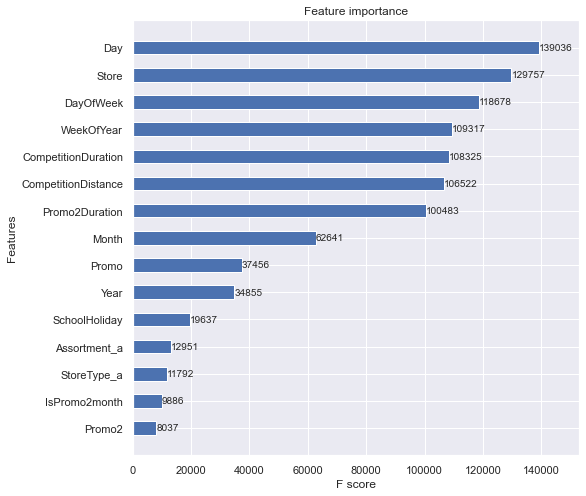

In [39]:
# plot feature importance, show top 15 features
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(bst, max_num_features= 15, height=0.5, ax=ax);

In [ ]:
# Save the best model
bst.save_model('my_model.model')

# Reload model
loaded_model = xgb.Booster()
loaded_model.load_model("my_model.model")

# And use it for predictions.
loaded_model.predict(dtest)

#### Model Fine-Tuning

Our XGBoost model returned a RMSPE value of 0.1396, which is much better than the Random Forest Model. If you spent a bit more time tuning the hyperparameters, you might be able to improve your model even further.

You can use GridSearchCV to search optimal parameters as we did for the RandomForest Model. However, let's just try RandomizedSearchCV here and see if it can return a better result!

In [115]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

In [116]:
# xgb_model = xgb.XGBRegressor()    # Scikit-Learn Wrapper interface for XGBoost

# param_grid = {
#         'learning_rate': st.uniform(0.001, 1),
#         'min_child_weight': st.uniform(0, 15),
#         'gamma': st.uniform(0, 10),
#         'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#         'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#         'max_depth': [4, 6, 8, 10, 15, 20],
#         'n_estimators': [300,  500, 1000, 2000]
#               }

# clf = RandomizedSearchCV(xgb_model, param_grid,
#                          scoring=make_scorer(rmspe,greater_is_better=False), 
#                          n_jobs=-1, cv=5, verbose=4, random_state=42)

# clf.fit(X_train,y_train,  early_stopping_rounds=200,
#         eval_set=[(X_valid, y_valid)])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 102.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 235.4min finished


[13:51:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.79106
Will train until validation_0-rmse hasn't improved in 200 rounds.
[1]	validation_0-rmse:5.55039
[2]	validation_0-rmse:4.53769
[3]	validation_0-rmse:3.71499
[4]	validation_0-rmse:3.04428
[5]	validation_0-rmse:2.49906
[6]	validation_0-rmse:2.05226
[7]	validation_0-rmse:1.69124
[8]	validation_0-rmse:1.39509
[9]	validation_0-rmse:1.15692
[10]	validation_0-rmse:0.964464
[11]	validation_0-rmse:0.80837
[12]	validation_0-rmse:0.684144
[13]	validation_0-rmse:0.584883
[14]	validation_0-rmse:0.504324
[15]	validation_0-rmse:0.440315
[16]	validation_0-rmse:0.391448
[17]	validation_0-rmse:0.35486
[18]	validation_0-rmse:0.324734
[19]	validation_0-rmse:0.303521
[20]	validation_0-rmse:0.287871
[21]	validation_0-rmse:0.277534
[22]	validation_0-rmse:0.265747
[23]	validation_0-rmse:0.257044
[24]	validation_0-rmse:0

[246]	validation_0-rmse:0.149797
[247]	validation_0-rmse:0.149797
[248]	validation_0-rmse:0.149798
[249]	validation_0-rmse:0.149792
[250]	validation_0-rmse:0.149723
[251]	validation_0-rmse:0.149698
[252]	validation_0-rmse:0.149698
[253]	validation_0-rmse:0.149679
[254]	validation_0-rmse:0.149678
[255]	validation_0-rmse:0.149674
[256]	validation_0-rmse:0.14968
[257]	validation_0-rmse:0.149679
[258]	validation_0-rmse:0.149673
[259]	validation_0-rmse:0.149661
[260]	validation_0-rmse:0.149656
[261]	validation_0-rmse:0.149604
[262]	validation_0-rmse:0.149577
[263]	validation_0-rmse:0.149549
[264]	validation_0-rmse:0.14942
[265]	validation_0-rmse:0.149419
[266]	validation_0-rmse:0.149512
[267]	validation_0-rmse:0.149447
[268]	validation_0-rmse:0.149448
[269]	validation_0-rmse:0.149395
[270]	validation_0-rmse:0.149394
[271]	validation_0-rmse:0.14916
[272]	validation_0-rmse:0.149124
[273]	validation_0-rmse:0.149133
[274]	validation_0-rmse:0.149133
[275]	validation_0-rmse:0.149108
[276]	validat

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_st...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000127A9965748>,
                                        'max_depth': [4,

In [117]:
print(clf.best_score_)
print(clf.best_params_)

-0.019386482879626275
{'colsample_bytree': 0.7, 'gamma': 1.8182496720710062, 'learning_rate': 0.18440450985343382, 'max_depth': 10, 'min_child_weight': 9.174797407324213, 'n_estimators': 300, 'subsample': 0.9}


In [105]:
clf.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=4.592488919658671,
             importance_type='gain', learning_rate=0.33470861113902184,
             max_delta_step=0, max_depth=10,
             min_child_weight=10.621088666940683, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1.0, verbosity=1)

In [118]:
y_pred = clf.best_estimator_.predict(X_valid)

error = rmspe(np.exp(y_valid), np.exp(y_pred))

# Print the error:
print("Valid RMSPE: %.6f" % error)

Valid RMSPE: 0.152775


This didn't give us the best results, so let's try to feed the new parameters into the original model and train again.

In [119]:
params = {'colsample_bytree': 0.7, 
          'gamma': 1.8182496720710062, 
          'learning_rate': 0.18440450985343382, 
          'max_depth': 10, 
          'min_child_weight': 9.174797407324213, 
          'n_estimators': 300, 
          'subsample': 0.9}

num_round = 6000   
bst = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_round, 
                evals=evallist, early_stopping_rounds=200, 
                feval=rmspe_xg, verbose_eval=True

[0]	train-rmse:6.74316	valid-rmse:6.79106	train-rmspe:0.998704	valid-rmspe:0.998775
Multiple eval metrics have been passed: 'valid-rmspe' will be used for early stopping.

Will train until valid-rmspe hasn't improved in 200 rounds.
[1]	train-rmse:5.50332	valid-rmse:5.55039	train-rmspe:0.995559	valid-rmspe:0.995796
[2]	train-rmse:4.49292	valid-rmse:4.53769	train-rmspe:0.987854	valid-rmspe:0.988463
[3]	train-rmse:3.66954	valid-rmse:3.71499	train-rmspe:0.972403	valid-rmspe:0.973774
[4]	train-rmse:2.99878	valid-rmse:3.04428	train-rmspe:0.946231	valid-rmspe:0.94886
[5]	train-rmse:2.45269	valid-rmse:2.49906	train-rmspe:0.907486	valid-rmspe:0.911997
[6]	train-rmse:2.00888	valid-rmse:2.05226	train-rmspe:0.85614	valid-rmspe:0.862538
[7]	train-rmse:1.64829	valid-rmse:1.69124	train-rmspe:0.794423	valid-rmspe:0.803077
[8]	train-rmse:1.35331	valid-rmse:1.39509	train-rmspe:0.726293	valid-rmspe:0.736803
[9]	train-rmse:1.11627	valid-rmse:1.15692	train-rmspe:0.654828	valid-rmspe:0.666854
[10]	train-rms

[94]	train-rmse:0.137764	valid-rmse:0.166109	train-rmspe:0.209245	valid-rmspe:0.170346
[95]	train-rmse:0.137641	valid-rmse:0.16615	train-rmspe:0.209154	valid-rmspe:0.170383
[96]	train-rmse:0.137171	valid-rmse:0.16575	train-rmspe:0.208801	valid-rmspe:0.169982
[97]	train-rmse:0.13713	valid-rmse:0.165699	train-rmspe:0.208924	valid-rmspe:0.169929
[98]	train-rmse:0.136986	valid-rmse:0.165536	train-rmspe:0.208796	valid-rmspe:0.169697
[99]	train-rmse:0.136376	valid-rmse:0.165037	train-rmspe:0.207771	valid-rmspe:0.169147
[100]	train-rmse:0.13595	valid-rmse:0.164804	train-rmspe:0.207213	valid-rmspe:0.168994
[101]	train-rmse:0.135777	valid-rmse:0.164742	train-rmspe:0.207049	valid-rmspe:0.16903
[102]	train-rmse:0.135777	valid-rmse:0.164744	train-rmspe:0.207043	valid-rmspe:0.169027
[103]	train-rmse:0.135213	valid-rmse:0.164242	train-rmspe:0.206575	valid-rmspe:0.168491
[104]	train-rmse:0.135168	valid-rmse:0.164243	train-rmspe:0.206517	valid-rmspe:0.168445
[105]	train-rmse:0.135073	valid-rmse:0.1640

[188]	train-rmse:0.122435	valid-rmse:0.152255	train-rmspe:0.198246	valid-rmspe:0.156201
[189]	train-rmse:0.122341	valid-rmse:0.15218	train-rmspe:0.198182	valid-rmspe:0.156124
[190]	train-rmse:0.122201	valid-rmse:0.152048	train-rmspe:0.198096	valid-rmspe:0.155983
[191]	train-rmse:0.121926	valid-rmse:0.151792	train-rmspe:0.197799	valid-rmspe:0.155638
[192]	train-rmse:0.12173	valid-rmse:0.151635	train-rmspe:0.19763	valid-rmspe:0.155509
[193]	train-rmse:0.121683	valid-rmse:0.151612	train-rmspe:0.197585	valid-rmspe:0.155495
[194]	train-rmse:0.121544	valid-rmse:0.151476	train-rmspe:0.197304	valid-rmspe:0.15537
[195]	train-rmse:0.121529	valid-rmse:0.151491	train-rmspe:0.197289	valid-rmspe:0.155719
[196]	train-rmse:0.12151	valid-rmse:0.151474	train-rmspe:0.197255	valid-rmspe:0.155688
[197]	train-rmse:0.121169	valid-rmse:0.151157	train-rmspe:0.19689	valid-rmspe:0.155233
[198]	train-rmse:0.121163	valid-rmse:0.151151	train-rmspe:0.196887	valid-rmspe:0.155227
[199]	train-rmse:0.121128	valid-rmse:0

[282]	train-rmse:0.118706	valid-rmse:0.149049	train-rmspe:0.194897	valid-rmspe:0.153148
[283]	train-rmse:0.118693	valid-rmse:0.149037	train-rmspe:0.194886	valid-rmspe:0.153137
[284]	train-rmse:0.118693	valid-rmse:0.149036	train-rmspe:0.194889	valid-rmspe:0.153139
[285]	train-rmse:0.118693	valid-rmse:0.149037	train-rmspe:0.194887	valid-rmspe:0.153137
[286]	train-rmse:0.118682	valid-rmse:0.149018	train-rmspe:0.194871	valid-rmspe:0.15312
[287]	train-rmse:0.118602	valid-rmse:0.148986	train-rmspe:0.194809	valid-rmspe:0.153081
[288]	train-rmse:0.118597	valid-rmse:0.148979	train-rmspe:0.194805	valid-rmspe:0.153076
[289]	train-rmse:0.118571	valid-rmse:0.14894	train-rmspe:0.194799	valid-rmspe:0.153017
[290]	train-rmse:0.118514	valid-rmse:0.148883	train-rmspe:0.194746	valid-rmspe:0.152956
[291]	train-rmse:0.118514	valid-rmse:0.148884	train-rmspe:0.194744	valid-rmspe:0.152955
[292]	train-rmse:0.118506	valid-rmse:0.148868	train-rmspe:0.194738	valid-rmspe:0.152942
[293]	train-rmse:0.118506	valid-rm

[376]	train-rmse:0.117113	valid-rmse:0.147775	train-rmspe:0.193752	valid-rmspe:0.15205
[377]	train-rmse:0.117085	valid-rmse:0.147755	train-rmspe:0.193757	valid-rmspe:0.152037
[378]	train-rmse:0.117043	valid-rmse:0.147728	train-rmspe:0.193725	valid-rmspe:0.151987
[379]	train-rmse:0.117043	valid-rmse:0.147727	train-rmspe:0.193726	valid-rmspe:0.151988
[380]	train-rmse:0.117033	valid-rmse:0.147723	train-rmspe:0.193721	valid-rmspe:0.15198
[381]	train-rmse:0.117025	valid-rmse:0.147711	train-rmspe:0.193713	valid-rmspe:0.151958
[382]	train-rmse:0.116999	valid-rmse:0.147679	train-rmspe:0.193673	valid-rmspe:0.151931
[383]	train-rmse:0.116999	valid-rmse:0.147678	train-rmspe:0.193674	valid-rmspe:0.151932
[384]	train-rmse:0.116999	valid-rmse:0.147677	train-rmspe:0.193678	valid-rmspe:0.151934
[385]	train-rmse:0.116965	valid-rmse:0.147655	train-rmspe:0.193656	valid-rmspe:0.151904
[386]	train-rmse:0.116954	valid-rmse:0.147643	train-rmspe:0.193647	valid-rmspe:0.151883
[387]	train-rmse:0.116954	valid-rm

[470]	train-rmse:0.11629	valid-rmse:0.147133	train-rmspe:0.193089	valid-rmspe:0.151272
[471]	train-rmse:0.11629	valid-rmse:0.147133	train-rmspe:0.19309	valid-rmspe:0.151273
[472]	train-rmse:0.11629	valid-rmse:0.147133	train-rmspe:0.193089	valid-rmspe:0.151272
[473]	train-rmse:0.11629	valid-rmse:0.147133	train-rmspe:0.193089	valid-rmspe:0.151272
[474]	train-rmse:0.11629	valid-rmse:0.147133	train-rmspe:0.193088	valid-rmspe:0.151271
[475]	train-rmse:0.11629	valid-rmse:0.147133	train-rmspe:0.193088	valid-rmspe:0.151272
[476]	train-rmse:0.11629	valid-rmse:0.147133	train-rmspe:0.193089	valid-rmspe:0.151272
[477]	train-rmse:0.11629	valid-rmse:0.147134	train-rmspe:0.193085	valid-rmspe:0.15127
[478]	train-rmse:0.11629	valid-rmse:0.147135	train-rmspe:0.193084	valid-rmspe:0.151269
[479]	train-rmse:0.11629	valid-rmse:0.147135	train-rmspe:0.193084	valid-rmspe:0.151269
[480]	train-rmse:0.11629	valid-rmse:0.147135	train-rmspe:0.193083	valid-rmspe:0.151269
[481]	train-rmse:0.11629	valid-rmse:0.147134	

[564]	train-rmse:0.115999	valid-rmse:0.147049	train-rmspe:0.192913	valid-rmspe:0.15135
[565]	train-rmse:0.115999	valid-rmse:0.147049	train-rmspe:0.192912	valid-rmspe:0.151349
[566]	train-rmse:0.115999	valid-rmse:0.147049	train-rmspe:0.192912	valid-rmspe:0.151349
[567]	train-rmse:0.115999	valid-rmse:0.14705	train-rmspe:0.19291	valid-rmspe:0.151348
[568]	train-rmse:0.115999	valid-rmse:0.14705	train-rmspe:0.192909	valid-rmspe:0.151347
[569]	train-rmse:0.115999	valid-rmse:0.14705	train-rmspe:0.192911	valid-rmspe:0.151348
[570]	train-rmse:0.115999	valid-rmse:0.147049	train-rmspe:0.192913	valid-rmspe:0.15135
[571]	train-rmse:0.115999	valid-rmse:0.14705	train-rmspe:0.19291	valid-rmspe:0.151348
[572]	train-rmse:0.115999	valid-rmse:0.14705	train-rmspe:0.192911	valid-rmspe:0.151349
[573]	train-rmse:0.115999	valid-rmse:0.14705	train-rmspe:0.19291	valid-rmspe:0.151348
[574]	train-rmse:0.115999	valid-rmse:0.147049	train-rmspe:0.192912	valid-rmspe:0.151349
[575]	train-rmse:0.115999	valid-rmse:0.1470

[658]	train-rmse:0.115741	valid-rmse:0.146946	train-rmspe:0.187132	valid-rmspe:0.151208
[659]	train-rmse:0.115741	valid-rmse:0.146946	train-rmspe:0.187133	valid-rmspe:0.151208
[660]	train-rmse:0.115741	valid-rmse:0.146946	train-rmspe:0.187133	valid-rmspe:0.151209
[661]	train-rmse:0.115682	valid-rmse:0.146906	train-rmspe:0.187096	valid-rmspe:0.151162
[662]	train-rmse:0.115682	valid-rmse:0.146905	train-rmspe:0.187097	valid-rmspe:0.151163
[663]	train-rmse:0.115649	valid-rmse:0.146881	train-rmspe:0.18707	valid-rmspe:0.15114
[664]	train-rmse:0.115649	valid-rmse:0.146881	train-rmspe:0.18707	valid-rmspe:0.15114
[665]	train-rmse:0.115641	valid-rmse:0.146872	train-rmspe:0.187064	valid-rmspe:0.151126
[666]	train-rmse:0.115641	valid-rmse:0.146873	train-rmspe:0.187062	valid-rmspe:0.151125
[667]	train-rmse:0.115641	valid-rmse:0.146873	train-rmspe:0.187063	valid-rmspe:0.151125
[668]	train-rmse:0.115641	valid-rmse:0.146872	train-rmspe:0.187064	valid-rmspe:0.151126
[669]	train-rmse:0.115641	valid-rmse

[752]	train-rmse:0.11527	valid-rmse:0.146606	train-rmspe:0.186493	valid-rmspe:0.150874
[753]	train-rmse:0.115263	valid-rmse:0.146599	train-rmspe:0.186492	valid-rmspe:0.150867
[754]	train-rmse:0.115263	valid-rmse:0.1466	train-rmspe:0.186489	valid-rmspe:0.150865
[755]	train-rmse:0.115263	valid-rmse:0.146601	train-rmspe:0.186487	valid-rmspe:0.150864
[756]	train-rmse:0.115254	valid-rmse:0.146585	train-rmspe:0.18648	valid-rmspe:0.150848
[757]	train-rmse:0.11524	valid-rmse:0.146563	train-rmspe:0.186465	valid-rmspe:0.150887
[758]	train-rmse:0.115231	valid-rmse:0.146549	train-rmspe:0.186462	valid-rmspe:0.150873
[759]	train-rmse:0.115195	valid-rmse:0.146602	train-rmspe:0.186438	valid-rmspe:0.150823
[760]	train-rmse:0.115195	valid-rmse:0.1466	train-rmspe:0.186441	valid-rmspe:0.150825
[761]	train-rmse:0.115195	valid-rmse:0.1466	train-rmspe:0.186441	valid-rmspe:0.150825
[762]	train-rmse:0.115195	valid-rmse:0.146601	train-rmspe:0.186439	valid-rmspe:0.150824
[763]	train-rmse:0.115195	valid-rmse:0.14

[846]	train-rmse:0.114852	valid-rmse:0.146414	train-rmspe:0.186196	valid-rmspe:0.150648
[847]	train-rmse:0.114852	valid-rmse:0.146414	train-rmspe:0.186197	valid-rmspe:0.150648
[848]	train-rmse:0.11481	valid-rmse:0.146393	train-rmspe:0.186173	valid-rmspe:0.150618
[849]	train-rmse:0.11481	valid-rmse:0.146392	train-rmspe:0.186175	valid-rmspe:0.150619
[850]	train-rmse:0.11481	valid-rmse:0.146391	train-rmspe:0.186178	valid-rmspe:0.150621
[851]	train-rmse:0.11481	valid-rmse:0.146392	train-rmspe:0.186177	valid-rmspe:0.15062
[852]	train-rmse:0.11481	valid-rmse:0.146392	train-rmspe:0.186175	valid-rmspe:0.150619
[853]	train-rmse:0.11481	valid-rmse:0.146392	train-rmspe:0.186176	valid-rmspe:0.150619
[854]	train-rmse:0.11481	valid-rmse:0.146391	train-rmspe:0.186179	valid-rmspe:0.150621
[855]	train-rmse:0.11481	valid-rmse:0.146391	train-rmspe:0.186178	valid-rmspe:0.150621
[856]	train-rmse:0.114798	valid-rmse:0.146382	train-rmspe:0.186178	valid-rmspe:0.150638
[857]	train-rmse:0.114798	valid-rmse:0.14

[940]	train-rmse:0.114663	valid-rmse:0.146331	train-rmspe:0.186114	valid-rmspe:0.150686
[941]	train-rmse:0.114663	valid-rmse:0.146331	train-rmspe:0.186115	valid-rmspe:0.150687
[942]	train-rmse:0.114655	valid-rmse:0.146327	train-rmspe:0.186105	valid-rmspe:0.150683
[943]	train-rmse:0.114655	valid-rmse:0.146327	train-rmspe:0.186104	valid-rmspe:0.150683
[944]	train-rmse:0.114655	valid-rmse:0.146328	train-rmspe:0.186103	valid-rmspe:0.150682
[945]	train-rmse:0.11464	valid-rmse:0.146306	train-rmspe:0.186128	valid-rmspe:0.150642
[946]	train-rmse:0.11464	valid-rmse:0.146306	train-rmspe:0.186129	valid-rmspe:0.150643
[947]	train-rmse:0.11464	valid-rmse:0.146306	train-rmspe:0.186129	valid-rmspe:0.150643
[948]	train-rmse:0.114602	valid-rmse:0.146281	train-rmspe:0.186106	valid-rmspe:0.15061
[949]	train-rmse:0.114602	valid-rmse:0.146281	train-rmspe:0.186105	valid-rmspe:0.150609
[950]	train-rmse:0.114602	valid-rmse:0.146283	train-rmspe:0.186101	valid-rmspe:0.150606
[951]	train-rmse:0.114602	valid-rmse

[1034]	train-rmse:0.114351	valid-rmse:0.146038	train-rmspe:0.185716	valid-rmspe:0.150382
[1035]	train-rmse:0.114351	valid-rmse:0.146039	train-rmspe:0.185714	valid-rmspe:0.150381
[1036]	train-rmse:0.114342	valid-rmse:0.146039	train-rmspe:0.185713	valid-rmspe:0.150379
[1037]	train-rmse:0.114342	valid-rmse:0.146041	train-rmspe:0.185709	valid-rmspe:0.150377
[1038]	train-rmse:0.114331	valid-rmse:0.146033	train-rmspe:0.185723	valid-rmspe:0.150372
[1039]	train-rmse:0.114331	valid-rmse:0.146033	train-rmspe:0.185722	valid-rmspe:0.150372
[1040]	train-rmse:0.114331	valid-rmse:0.146033	train-rmspe:0.185723	valid-rmspe:0.150372
[1041]	train-rmse:0.114323	valid-rmse:0.146031	train-rmspe:0.183073	valid-rmspe:0.150375
[1042]	train-rmse:0.114323	valid-rmse:0.146031	train-rmspe:0.183074	valid-rmspe:0.150375
[1043]	train-rmse:0.114323	valid-rmse:0.146033	train-rmspe:0.183068	valid-rmspe:0.150372
[1044]	train-rmse:0.114323	valid-rmse:0.146035	train-rmspe:0.183064	valid-rmspe:0.150369
[1045]	train-rmse:0.1

[1127]	train-rmse:0.114177	valid-rmse:0.145941	train-rmspe:0.182923	valid-rmspe:0.150322
[1128]	train-rmse:0.11417	valid-rmse:0.145945	train-rmspe:0.182934	valid-rmspe:0.150324
[1129]	train-rmse:0.11417	valid-rmse:0.145946	train-rmspe:0.182932	valid-rmspe:0.150323
[1130]	train-rmse:0.11417	valid-rmse:0.145946	train-rmspe:0.182931	valid-rmspe:0.150323
[1131]	train-rmse:0.11417	valid-rmse:0.145946	train-rmspe:0.182933	valid-rmspe:0.150324
[1132]	train-rmse:0.11417	valid-rmse:0.145946	train-rmspe:0.182932	valid-rmspe:0.150323
[1133]	train-rmse:0.11417	valid-rmse:0.145946	train-rmspe:0.182931	valid-rmspe:0.150323
[1134]	train-rmse:0.11417	valid-rmse:0.145946	train-rmspe:0.182931	valid-rmspe:0.150322
[1135]	train-rmse:0.11417	valid-rmse:0.145946	train-rmspe:0.182931	valid-rmspe:0.150323
[1136]	train-rmse:0.11417	valid-rmse:0.145945	train-rmspe:0.182934	valid-rmspe:0.150324
[1137]	train-rmse:0.11417	valid-rmse:0.145946	train-rmspe:0.182933	valid-rmspe:0.150324
[1138]	train-rmse:0.11417	valid

[1220]	train-rmse:0.114068	valid-rmse:0.145742	train-rmspe:0.182838	valid-rmspe:0.150073
[1221]	train-rmse:0.114068	valid-rmse:0.145742	train-rmspe:0.182839	valid-rmspe:0.150073
[1222]	train-rmse:0.114068	valid-rmse:0.145742	train-rmspe:0.182839	valid-rmspe:0.150073
[1223]	train-rmse:0.114068	valid-rmse:0.145742	train-rmspe:0.182839	valid-rmspe:0.150073
[1224]	train-rmse:0.114068	valid-rmse:0.145741	train-rmspe:0.18284	valid-rmspe:0.150074
[1225]	train-rmse:0.114068	valid-rmse:0.145742	train-rmspe:0.182838	valid-rmspe:0.150073
[1226]	train-rmse:0.114068	valid-rmse:0.145743	train-rmspe:0.182836	valid-rmspe:0.150071
[1227]	train-rmse:0.114068	valid-rmse:0.145744	train-rmspe:0.182834	valid-rmspe:0.15007
[1228]	train-rmse:0.114068	valid-rmse:0.145744	train-rmspe:0.182833	valid-rmspe:0.150069
[1229]	train-rmse:0.114068	valid-rmse:0.145743	train-rmspe:0.182836	valid-rmspe:0.150071
[1230]	train-rmse:0.114068	valid-rmse:0.145744	train-rmspe:0.182834	valid-rmspe:0.15007
[1231]	train-rmse:0.1140

[1313]	train-rmse:0.11401	valid-rmse:0.14569	train-rmspe:0.182794	valid-rmspe:0.150019
[1314]	train-rmse:0.11401	valid-rmse:0.14569	train-rmspe:0.182795	valid-rmspe:0.150019
[1315]	train-rmse:0.11401	valid-rmse:0.14569	train-rmspe:0.182793	valid-rmspe:0.150018
[1316]	train-rmse:0.11401	valid-rmse:0.145691	train-rmspe:0.182791	valid-rmspe:0.150016
[1317]	train-rmse:0.11401	valid-rmse:0.145691	train-rmspe:0.182791	valid-rmspe:0.150017
[1318]	train-rmse:0.11401	valid-rmse:0.145691	train-rmspe:0.182792	valid-rmspe:0.150017
[1319]	train-rmse:0.11401	valid-rmse:0.14569	train-rmspe:0.182794	valid-rmspe:0.150018
[1320]	train-rmse:0.11401	valid-rmse:0.145689	train-rmspe:0.182797	valid-rmspe:0.15002
[1321]	train-rmse:0.11401	valid-rmse:0.145689	train-rmspe:0.182797	valid-rmspe:0.15002
[1322]	train-rmse:0.114	valid-rmse:0.145648	train-rmspe:0.182781	valid-rmspe:0.149956
[1323]	train-rmse:0.114	valid-rmse:0.145649	train-rmspe:0.182778	valid-rmspe:0.149954
[1324]	train-rmse:0.114	valid-rmse:0.14565

[1406]	train-rmse:0.113934	valid-rmse:0.145618	train-rmspe:0.182747	valid-rmspe:0.149896
[1407]	train-rmse:0.113934	valid-rmse:0.145617	train-rmspe:0.18275	valid-rmspe:0.149898
[1408]	train-rmse:0.113934	valid-rmse:0.145618	train-rmspe:0.182748	valid-rmspe:0.149897
[1409]	train-rmse:0.113934	valid-rmse:0.145618	train-rmspe:0.182748	valid-rmspe:0.149897
[1410]	train-rmse:0.113934	valid-rmse:0.145619	train-rmspe:0.182746	valid-rmspe:0.149896
[1411]	train-rmse:0.113924	valid-rmse:0.145609	train-rmspe:0.18299	valid-rmspe:0.149889
[1412]	train-rmse:0.113924	valid-rmse:0.145608	train-rmspe:0.182992	valid-rmspe:0.14989
[1413]	train-rmse:0.113924	valid-rmse:0.145608	train-rmspe:0.182991	valid-rmspe:0.14989
[1414]	train-rmse:0.113924	valid-rmse:0.145608	train-rmspe:0.182993	valid-rmspe:0.149891
[1415]	train-rmse:0.113924	valid-rmse:0.145609	train-rmspe:0.18299	valid-rmspe:0.149889
[1416]	train-rmse:0.113924	valid-rmse:0.14561	train-rmspe:0.182987	valid-rmspe:0.149887
[1417]	train-rmse:0.113924	

[1499]	train-rmse:0.113785	valid-rmse:0.145578	train-rmspe:0.182861	valid-rmspe:0.14991
[1500]	train-rmse:0.113785	valid-rmse:0.145577	train-rmspe:0.182864	valid-rmspe:0.149912
[1501]	train-rmse:0.113785	valid-rmse:0.145578	train-rmspe:0.182862	valid-rmspe:0.14991
[1502]	train-rmse:0.113785	valid-rmse:0.145579	train-rmspe:0.182859	valid-rmspe:0.149908
[1503]	train-rmse:0.113785	valid-rmse:0.145578	train-rmspe:0.182862	valid-rmspe:0.14991
[1504]	train-rmse:0.113785	valid-rmse:0.145577	train-rmspe:0.182863	valid-rmspe:0.149911
[1505]	train-rmse:0.113785	valid-rmse:0.145578	train-rmspe:0.182862	valid-rmspe:0.14991
[1506]	train-rmse:0.113775	valid-rmse:0.145579	train-rmspe:0.182856	valid-rmspe:0.149916
[1507]	train-rmse:0.113775	valid-rmse:0.145579	train-rmspe:0.182854	valid-rmspe:0.149915
[1508]	train-rmse:0.113775	valid-rmse:0.145579	train-rmspe:0.182855	valid-rmspe:0.149915
[1509]	train-rmse:0.113775	valid-rmse:0.14558	train-rmspe:0.182852	valid-rmspe:0.149914
[1510]	train-rmse:0.113775

[1593]	train-rmse:0.11374	valid-rmse:0.145567	train-rmspe:0.182835	valid-rmspe:0.14989
[1594]	train-rmse:0.113731	valid-rmse:0.145546	train-rmspe:0.182822	valid-rmspe:0.149868
[1595]	train-rmse:0.113725	valid-rmse:0.145538	train-rmspe:0.183335	valid-rmspe:0.149861
[1596]	train-rmse:0.113725	valid-rmse:0.145538	train-rmspe:0.183335	valid-rmspe:0.149861
[1597]	train-rmse:0.113725	valid-rmse:0.145538	train-rmspe:0.183333	valid-rmspe:0.14986
[1598]	train-rmse:0.113725	valid-rmse:0.145537	train-rmspe:0.183337	valid-rmspe:0.149862
[1599]	train-rmse:0.113725	valid-rmse:0.145536	train-rmspe:0.18334	valid-rmspe:0.149864
[1600]	train-rmse:0.113725	valid-rmse:0.145537	train-rmspe:0.183336	valid-rmspe:0.149862
[1601]	train-rmse:0.113725	valid-rmse:0.145537	train-rmspe:0.183338	valid-rmspe:0.149862
[1602]	train-rmse:0.113725	valid-rmse:0.145536	train-rmspe:0.183339	valid-rmspe:0.149863
[1603]	train-rmse:0.113725	valid-rmse:0.145536	train-rmspe:0.183339	valid-rmspe:0.149864
[1604]	train-rmse:0.11372

[1686]	train-rmse:0.113669	valid-rmse:0.145483	train-rmspe:0.178773	valid-rmspe:0.149772
[1687]	train-rmse:0.113669	valid-rmse:0.145483	train-rmspe:0.178773	valid-rmspe:0.149773
[1688]	train-rmse:0.113653	valid-rmse:0.145473	train-rmspe:0.178762	valid-rmspe:0.149766
[1689]	train-rmse:0.113653	valid-rmse:0.145473	train-rmspe:0.178761	valid-rmspe:0.149766
[1690]	train-rmse:0.113653	valid-rmse:0.145474	train-rmspe:0.178759	valid-rmspe:0.149764
[1691]	train-rmse:0.113653	valid-rmse:0.145474	train-rmspe:0.17876	valid-rmspe:0.149765
[1692]	train-rmse:0.113653	valid-rmse:0.145474	train-rmspe:0.178761	valid-rmspe:0.149765
[1693]	train-rmse:0.113653	valid-rmse:0.145473	train-rmspe:0.178763	valid-rmspe:0.149767
[1694]	train-rmse:0.113653	valid-rmse:0.145472	train-rmspe:0.178765	valid-rmspe:0.149768
[1695]	train-rmse:0.113653	valid-rmse:0.145473	train-rmspe:0.178764	valid-rmspe:0.149767
[1696]	train-rmse:0.113653	valid-rmse:0.145472	train-rmspe:0.178764	valid-rmspe:0.149768
[1697]	train-rmse:0.11

[1779]	train-rmse:0.11355	valid-rmse:0.145456	train-rmspe:0.178702	valid-rmspe:0.149757
[1780]	train-rmse:0.11355	valid-rmse:0.145455	train-rmspe:0.178704	valid-rmspe:0.149759
[1781]	train-rmse:0.11355	valid-rmse:0.145455	train-rmspe:0.178704	valid-rmspe:0.149758
[1782]	train-rmse:0.11355	valid-rmse:0.145456	train-rmspe:0.178703	valid-rmspe:0.149758
[1783]	train-rmse:0.11355	valid-rmse:0.145456	train-rmspe:0.178703	valid-rmspe:0.149758
[1784]	train-rmse:0.11355	valid-rmse:0.145456	train-rmspe:0.178702	valid-rmspe:0.149757
[1785]	train-rmse:0.11355	valid-rmse:0.145457	train-rmspe:0.1787	valid-rmspe:0.149756
[1786]	train-rmse:0.11355	valid-rmse:0.145457	train-rmspe:0.1787	valid-rmspe:0.149756
[1787]	train-rmse:0.11355	valid-rmse:0.145458	train-rmspe:0.178696	valid-rmspe:0.149753
[1788]	train-rmse:0.11355	valid-rmse:0.145458	train-rmspe:0.178696	valid-rmspe:0.149753
[1789]	train-rmse:0.11355	valid-rmse:0.145458	train-rmspe:0.178697	valid-rmspe:0.149754
[1790]	train-rmse:0.11355	valid-rmse

[1872]	train-rmse:0.113439	valid-rmse:0.145402	train-rmspe:0.178658	valid-rmspe:0.149725
[1873]	train-rmse:0.113439	valid-rmse:0.145402	train-rmspe:0.178659	valid-rmspe:0.149725
[1874]	train-rmse:0.113439	valid-rmse:0.145401	train-rmspe:0.178662	valid-rmspe:0.149727
[1875]	train-rmse:0.113439	valid-rmse:0.145401	train-rmspe:0.178661	valid-rmspe:0.149727
[1876]	train-rmse:0.113439	valid-rmse:0.1454	train-rmspe:0.178663	valid-rmspe:0.149728
[1877]	train-rmse:0.113439	valid-rmse:0.1454	train-rmspe:0.178663	valid-rmspe:0.149728
[1878]	train-rmse:0.113439	valid-rmse:0.145401	train-rmspe:0.178662	valid-rmspe:0.149727
[1879]	train-rmse:0.113439	valid-rmse:0.145401	train-rmspe:0.17866	valid-rmspe:0.149726
[1880]	train-rmse:0.113439	valid-rmse:0.145401	train-rmspe:0.178661	valid-rmspe:0.149727
[1881]	train-rmse:0.113439	valid-rmse:0.145401	train-rmspe:0.178662	valid-rmspe:0.149727
[1882]	train-rmse:0.113439	valid-rmse:0.145401	train-rmspe:0.178661	valid-rmspe:0.149727
[1883]	train-rmse:0.113439

[1965]	train-rmse:0.113275	valid-rmse:0.145188	train-rmspe:0.178517	valid-rmspe:0.149529
[1966]	train-rmse:0.113275	valid-rmse:0.145188	train-rmspe:0.178517	valid-rmspe:0.149529
[1967]	train-rmse:0.113266	valid-rmse:0.145188	train-rmspe:0.178467	valid-rmspe:0.149529
[1968]	train-rmse:0.113266	valid-rmse:0.145187	train-rmspe:0.178469	valid-rmspe:0.149531
[1969]	train-rmse:0.113266	valid-rmse:0.145186	train-rmspe:0.178472	valid-rmspe:0.149532
[1970]	train-rmse:0.113266	valid-rmse:0.145186	train-rmspe:0.178473	valid-rmspe:0.149533
[1971]	train-rmse:0.113266	valid-rmse:0.145186	train-rmspe:0.178471	valid-rmspe:0.149532
[1972]	train-rmse:0.113266	valid-rmse:0.145186	train-rmspe:0.178472	valid-rmspe:0.149532
[1973]	train-rmse:0.113266	valid-rmse:0.145186	train-rmspe:0.178473	valid-rmspe:0.149533
[1974]	train-rmse:0.113266	valid-rmse:0.145186	train-rmspe:0.178473	valid-rmspe:0.149533
[1975]	train-rmse:0.113266	valid-rmse:0.145186	train-rmspe:0.178472	valid-rmspe:0.149533
[1976]	train-rmse:0.1

[2058]	train-rmse:0.113207	valid-rmse:0.144998	train-rmspe:0.178462	valid-rmspe:0.149399
[2059]	train-rmse:0.113207	valid-rmse:0.144998	train-rmspe:0.178463	valid-rmspe:0.1494
[2060]	train-rmse:0.113207	valid-rmse:0.144999	train-rmspe:0.17846	valid-rmspe:0.149398
[2061]	train-rmse:0.113197	valid-rmse:0.144975	train-rmspe:0.178453	valid-rmspe:0.149377
[2062]	train-rmse:0.113197	valid-rmse:0.144975	train-rmspe:0.178453	valid-rmspe:0.149377
[2063]	train-rmse:0.113197	valid-rmse:0.144973	train-rmspe:0.178457	valid-rmspe:0.14938
[2064]	train-rmse:0.113197	valid-rmse:0.144972	train-rmspe:0.178461	valid-rmspe:0.149383
[2065]	train-rmse:0.113197	valid-rmse:0.144972	train-rmspe:0.17846	valid-rmspe:0.149382
[2066]	train-rmse:0.113197	valid-rmse:0.144973	train-rmspe:0.178459	valid-rmspe:0.149381
[2067]	train-rmse:0.113197	valid-rmse:0.144974	train-rmspe:0.178454	valid-rmspe:0.149378
[2068]	train-rmse:0.113197	valid-rmse:0.144974	train-rmspe:0.178455	valid-rmspe:0.149378
[2069]	train-rmse:0.113197

[2151]	train-rmse:0.113135	valid-rmse:0.144936	train-rmspe:0.178395	valid-rmspe:0.149388
[2152]	train-rmse:0.113135	valid-rmse:0.144936	train-rmspe:0.178395	valid-rmspe:0.149388
[2153]	train-rmse:0.113135	valid-rmse:0.144936	train-rmspe:0.178395	valid-rmspe:0.149388
[2154]	train-rmse:0.113135	valid-rmse:0.144936	train-rmspe:0.178394	valid-rmspe:0.149387
[2155]	train-rmse:0.113135	valid-rmse:0.144936	train-rmspe:0.178396	valid-rmspe:0.149389
[2156]	train-rmse:0.113135	valid-rmse:0.144935	train-rmspe:0.178398	valid-rmspe:0.14939
[2157]	train-rmse:0.113135	valid-rmse:0.144935	train-rmspe:0.178399	valid-rmspe:0.14939
[2158]	train-rmse:0.113135	valid-rmse:0.144934	train-rmspe:0.178401	valid-rmspe:0.149392
[2159]	train-rmse:0.113135	valid-rmse:0.144935	train-rmspe:0.178398	valid-rmspe:0.14939
[2160]	train-rmse:0.113128	valid-rmse:0.144926	train-rmspe:0.178395	valid-rmspe:0.149383
[2161]	train-rmse:0.113128	valid-rmse:0.144927	train-rmspe:0.178393	valid-rmspe:0.149381
[2162]	train-rmse:0.1131

[2244]	train-rmse:0.113066	valid-rmse:0.144872	train-rmspe:0.178374	valid-rmspe:0.149334
[2245]	train-rmse:0.113066	valid-rmse:0.144873	train-rmspe:0.17837	valid-rmspe:0.149332
[2246]	train-rmse:0.113066	valid-rmse:0.144873	train-rmspe:0.17837	valid-rmspe:0.149332
[2247]	train-rmse:0.113055	valid-rmse:0.14488	train-rmspe:0.178359	valid-rmspe:0.14933
[2248]	train-rmse:0.113055	valid-rmse:0.14488	train-rmspe:0.178359	valid-rmspe:0.14933
[2249]	train-rmse:0.113055	valid-rmse:0.14488	train-rmspe:0.178359	valid-rmspe:0.149331
[2250]	train-rmse:0.113055	valid-rmse:0.14488	train-rmspe:0.178358	valid-rmspe:0.14933
[2251]	train-rmse:0.113055	valid-rmse:0.14488	train-rmspe:0.178359	valid-rmspe:0.14933
[2252]	train-rmse:0.113055	valid-rmse:0.14488	train-rmspe:0.178359	valid-rmspe:0.14933
[2253]	train-rmse:0.113055	valid-rmse:0.144879	train-rmspe:0.178363	valid-rmspe:0.149333
[2254]	train-rmse:0.113055	valid-rmse:0.144879	train-rmspe:0.178361	valid-rmspe:0.149331
[2255]	train-rmse:0.113055	valid-r

[2337]	train-rmse:0.112994	valid-rmse:0.144831	train-rmspe:0.178283	valid-rmspe:0.149263
[2338]	train-rmse:0.112984	valid-rmse:0.144819	train-rmspe:0.178254	valid-rmspe:0.149248
[2339]	train-rmse:0.112984	valid-rmse:0.144819	train-rmspe:0.178253	valid-rmspe:0.149248
[2340]	train-rmse:0.112984	valid-rmse:0.144819	train-rmspe:0.178255	valid-rmspe:0.149249
[2341]	train-rmse:0.112984	valid-rmse:0.144818	train-rmspe:0.178255	valid-rmspe:0.149249
[2342]	train-rmse:0.112974	valid-rmse:0.144814	train-rmspe:0.178251	valid-rmspe:0.149239
[2343]	train-rmse:0.112974	valid-rmse:0.144815	train-rmspe:0.178248	valid-rmspe:0.149238
[2344]	train-rmse:0.112974	valid-rmse:0.144813	train-rmspe:0.178253	valid-rmspe:0.149241
[2345]	train-rmse:0.112974	valid-rmse:0.144814	train-rmspe:0.178252	valid-rmspe:0.14924
[2346]	train-rmse:0.112974	valid-rmse:0.144813	train-rmspe:0.178253	valid-rmspe:0.149241
[2347]	train-rmse:0.112974	valid-rmse:0.144814	train-rmspe:0.17825	valid-rmspe:0.149239
[2348]	train-rmse:0.112

[2430]	train-rmse:0.11289	valid-rmse:0.144724	train-rmspe:0.178071	valid-rmspe:0.149132
[2431]	train-rmse:0.11289	valid-rmse:0.144724	train-rmspe:0.178074	valid-rmspe:0.149134
[2432]	train-rmse:0.112879	valid-rmse:0.144725	train-rmspe:0.178019	valid-rmspe:0.149132
[2433]	train-rmse:0.112879	valid-rmse:0.144726	train-rmspe:0.178016	valid-rmspe:0.14913
[2434]	train-rmse:0.112879	valid-rmse:0.144726	train-rmspe:0.178016	valid-rmspe:0.14913
[2435]	train-rmse:0.112879	valid-rmse:0.144725	train-rmspe:0.178017	valid-rmspe:0.149131
[2436]	train-rmse:0.112872	valid-rmse:0.144726	train-rmspe:0.178015	valid-rmspe:0.149135
[2437]	train-rmse:0.112872	valid-rmse:0.144727	train-rmspe:0.178012	valid-rmspe:0.149133
[2438]	train-rmse:0.112872	valid-rmse:0.144727	train-rmspe:0.178012	valid-rmspe:0.149133
[2439]	train-rmse:0.112872	valid-rmse:0.144727	train-rmspe:0.178013	valid-rmspe:0.149133
[2440]	train-rmse:0.112872	valid-rmse:0.144726	train-rmspe:0.178013	valid-rmspe:0.149134
[2441]	train-rmse:0.11287

[2523]	train-rmse:0.112822	valid-rmse:0.144768	train-rmspe:0.178019	valid-rmspe:0.149223
[2524]	train-rmse:0.112822	valid-rmse:0.144767	train-rmspe:0.178021	valid-rmspe:0.149224
[2525]	train-rmse:0.112822	valid-rmse:0.144767	train-rmspe:0.178021	valid-rmspe:0.149225
[2526]	train-rmse:0.112822	valid-rmse:0.144767	train-rmspe:0.178021	valid-rmspe:0.149225
[2527]	train-rmse:0.112822	valid-rmse:0.144768	train-rmspe:0.178018	valid-rmspe:0.149223
[2528]	train-rmse:0.112822	valid-rmse:0.144767	train-rmspe:0.178022	valid-rmspe:0.149225
[2529]	train-rmse:0.112822	valid-rmse:0.144767	train-rmspe:0.178021	valid-rmspe:0.149225
[2530]	train-rmse:0.112822	valid-rmse:0.144768	train-rmspe:0.178019	valid-rmspe:0.149223
[2531]	train-rmse:0.112822	valid-rmse:0.144768	train-rmspe:0.178018	valid-rmspe:0.149223
[2532]	train-rmse:0.112822	valid-rmse:0.144768	train-rmspe:0.178018	valid-rmspe:0.149223
[2533]	train-rmse:0.112822	valid-rmse:0.144768	train-rmspe:0.178017	valid-rmspe:0.149222
[2534]	train-rmse:0.1

[2616]	train-rmse:0.11281	valid-rmse:0.144761	train-rmspe:0.178002	valid-rmspe:0.149225
[2617]	train-rmse:0.11281	valid-rmse:0.14476	train-rmspe:0.178004	valid-rmspe:0.149227
[2618]	train-rmse:0.11281	valid-rmse:0.144759	train-rmspe:0.178006	valid-rmspe:0.149228
[2619]	train-rmse:0.11281	valid-rmse:0.144761	train-rmspe:0.178002	valid-rmspe:0.149226
[2620]	train-rmse:0.11281	valid-rmse:0.14476	train-rmspe:0.178006	valid-rmspe:0.149228
[2621]	train-rmse:0.11281	valid-rmse:0.144759	train-rmspe:0.178008	valid-rmspe:0.149229
[2622]	train-rmse:0.11281	valid-rmse:0.144759	train-rmspe:0.178008	valid-rmspe:0.14923
[2623]	train-rmse:0.11281	valid-rmse:0.144759	train-rmspe:0.178007	valid-rmspe:0.149229
[2624]	train-rmse:0.11281	valid-rmse:0.144759	train-rmspe:0.178006	valid-rmspe:0.149228
[2625]	train-rmse:0.11281	valid-rmse:0.144759	train-rmspe:0.178007	valid-rmspe:0.149229
[2626]	train-rmse:0.11281	valid-rmse:0.144759	train-rmspe:0.178009	valid-rmspe:0.14923
[2627]	train-rmse:0.11281	valid-rmse

In [121]:
print("Best Score on Train set:", bst.best_score) 
print("Best iteration:", bst.best_iteration)
print("Best tree limit:", bst.best_ntree_limit)

Best Score on Train set: 0.149104
Best iteration: 2496
Best tree limit: 2497


In [122]:
y_pred = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)

error = rmspe(np.exp(y_valid), np.exp(y_pred))

# Print the error:
print("Valid RMSPE: %.4f" % error)

Valid RMSPE: 0.1491


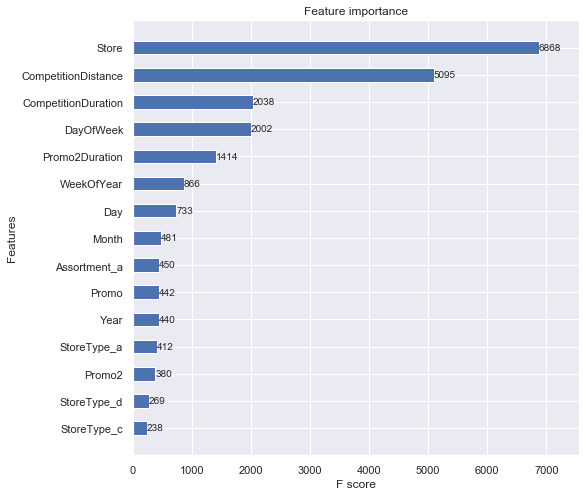

In [123]:
# plot feature importance, show top 15 features
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(bst, max_num_features= 15, height=0.5, ax=ax);